In [1]:
import os
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import proplot as pplt

# Plotly and cufflinks for data analysis
from plotly.offline import init_notebook_mode, iplot
import cufflinks as cf
init_notebook_mode(connected=True) 

cf.set_config_file(theme='ggplot')
cf.go_offline()

# Matplotlib for drawing the court
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.patches import Circle

%matplotlib inline

import seaborn as sb

from plotnine import ggplot, aes, geom_line
import plotly.graph_objects as go
from collections import Counter
from sklearn.linear_model import LinearRegression

# Importing datasets

In [2]:
pd.set_option('display.max_rows', 1000) 
events = pd.read_csv('events.csv')
points=pd.read_csv('points.csv')
rallies= pd.read_csv('rallies.csv')
serves= pd.read_csv('serves.csv') 


# Manipulation of Datasets

## Preparing the 'events' dataset for analysis

In [3]:
##Adding columns to events and rallies datasets to see which ones are in the points the dataset
events=events.assign(Inpoints=events.rallyid.isin(points.rallyid).astype(int))
rallies= rallies.assign(Inpoints=rallies.rallyid.isin(points.rallyid).astype(int))

##Creating subsets of the 'points' dataset by reason of point to make it easier to merge with the 'events' dataset.
winner_points=points[points['reason']=='winner']
ace_points = points[points['reason']=='ace']
out_points = points[points['reason']=='out']
net_points = points[points['reason']=='net']
dfault_points = points[points['reason']=='double_fault']


In [4]:
##Identifying the reason of the point in the 'events' dataset

events['type_of_point'] = ""

for i in range(864):
    if events.rallyid[i] in winner_points.rallyid.values:
        if "serve" in events.type.values[i]:
            if "first" in events.serve.values[i]:
                events['type_of_point'][i] = "winner"
            if "second" in events.serve.values[i]:
                events['type_of_point'][i] = "winner"
           
    
    if events.rallyid[i] in ace_points.rallyid.values:
        if events.rallyid[i+1] > events.rallyid[i]:
            events['type_of_point'][i] = "ace"
    
    if events.rallyid[i] in out_points.rallyid.values:
        if events.rallyid[i+1] > events.rallyid[i]:
            events['type_of_point'][i] = "out"
    
    if events.rallyid[i] in net_points.rallyid.values:
        if events.rallyid[i+1] > events.rallyid[i]:
            events['type_of_point'][i] = "net"
    
    if events.rallyid[i] in dfault_points.rallyid.values:
        if events.rallyid[i+1] > events.rallyid[i]:
            events['type_of_point'][i] = "double_fault"


In [5]:
##Creating a subset of the events dataframe to only include rallies that ended in a point
pts = events[events.type_of_point.str.len() >0]
missing= events[events["frameid"] ==256892] #Adding a missing rally that couldn't be added during the if/for loop
pts=pts.append(missing)

#Validating that the values of the events subset, that includes only the points, match with the points dataframe.
print((pts['Inpoints']==1).value_counts())
pts['rallyidp'] = ""
pts['rallyidp'] =points['rallyid'].values
pts[['rallyid','rallyidp']]

True    142
Name: Inpoints, dtype: int64


,rallyid,rallyidp
0,1,1
7,3,3
10,5,5
20,6,6
28,8,8
29,9,9
43,11,11
59,13,13
62,14,14
64,15,15


## Preparing the 'points' dataset for analysis

In [6]:
## Grouping the 'reason' of the point into categories.
##This will help identify the points that were earned by the winner, and the points that the winner gained because of its opponent's fault.

points['type of point']=""

conditions = [(points['reason']== 'net')|(points['reason']== 'out'),
             (points['reason']== 'ace') | (points['reason'] == 'winner'), 
             (points['reason']=='double_fault')]

values = ['fake point', 'earned point', 'missed point']
points['type of point']=np.select(conditions,values)

#points['score'] = points['score'].shift(-1)
points

,Unnamed: 0,rallyid,server,returner,winner,reason,serve,strokes,totaltime,x,y,score,type of point
0,0,1,Djokovic,Nadal,Djokovic,winner,first,3,0.92,1.92,21.96,"0:0, 15:0",earned point
1,2,3,Djokovic,Nadal,Djokovic,out,second,4,4.16,3.33,-0.39,"0:0, 30:0",fake point
2,4,5,Djokovic,Nadal,Djokovic,ace,second,2,0.40,1.62,17.18,"0:0, 40:0",earned point
3,5,6,Djokovic,Nadal,Djokovic,net,first,10,10.40,6.41,12.78,"1:0, 0:0",fake point
4,7,8,Nadal,Djokovic,Djokovic,out,second,7,7.20,0.50,18.67,"1:0, 15:0",fake point
5,8,9,Nadal,Djokovic,Djokovic,winner,first,12,0.92,3.65,9.50,"1:0, 30:0",earned point
6,10,11,Nadal,Djokovic,Nadal,winner,first,4,1.08,7.34,18.76,"1:0, 30:15",earned point
7,12,13,Nadal,Djokovic,Djokovic,net,second,13,13.60,4.01,11.37,"1:0, 40:15",fake point
8,13,14,Nadal,Djokovic,Djokovic,out,first,3,2.64,1.07,25.85,"2:0, 0:0",fake point
9,14,15,Djokovic,Nadal,Djokovic,out,first,2,0.80,4.39,27.45,"2:0, 15:0",fake point


In [7]:
points

,Unnamed: 0,rallyid,server,returner,winner,reason,serve,strokes,totaltime,x,y,score,type of point
0,0,1,Djokovic,Nadal,Djokovic,winner,first,3,0.92,1.92,21.96,"0:0, 15:0",earned point
1,2,3,Djokovic,Nadal,Djokovic,out,second,4,4.16,3.33,-0.39,"0:0, 30:0",fake point
2,4,5,Djokovic,Nadal,Djokovic,ace,second,2,0.40,1.62,17.18,"0:0, 40:0",earned point
3,5,6,Djokovic,Nadal,Djokovic,net,first,10,10.40,6.41,12.78,"1:0, 0:0",fake point
4,7,8,Nadal,Djokovic,Djokovic,out,second,7,7.20,0.50,18.67,"1:0, 15:0",fake point
5,8,9,Nadal,Djokovic,Djokovic,winner,first,12,0.92,3.65,9.50,"1:0, 30:0",earned point
6,10,11,Nadal,Djokovic,Nadal,winner,first,4,1.08,7.34,18.76,"1:0, 30:15",earned point
7,12,13,Nadal,Djokovic,Djokovic,net,second,13,13.60,4.01,11.37,"1:0, 40:15",fake point
8,13,14,Nadal,Djokovic,Djokovic,out,first,3,2.64,1.07,25.85,"2:0, 0:0",fake point
9,14,15,Djokovic,Nadal,Djokovic,out,first,2,0.80,4.39,27.45,"2:0, 15:0",fake point


## Adding 'points' columns to the 'pts' (events dataset only containing points) dataframe

In [8]:
pts['grouped_point']=points['type of point'].values
pts['x']=points['x'].values
pts['y']=points['y'].values
pts['score']=points['score'].values
pts['winner']=points['winner'].values
pts['server']=points['server'].values
ptss=pts[['rallyid','hitter','server', 'winner','receiver','stroke','type','hitter_x', 'hitter_y', 'receiver_x', 'receiver_y','x','y','type_of_point','grouped_point','score']]
ptss['reason_tp']= ""
ptss['hitter_tp']=""
ptss['winner_tp']=""
ptss=ptss.reset_index()
ptss

for i in range(141):
    ptss['reason_tp'][i]= ptss['type_of_point'][i+1]
    ptss['hitter_tp'][i]= ptss['hitter'][i+1]
    ptss['winner_tp'][i]= ptss['winner'][i+1]

ptss

,index,rallyid,hitter,server,winner,receiver,stroke,type,hitter_x,hitter_y,receiver_x,receiver_y,x,y,type_of_point,grouped_point,score,reason_tp,hitter_tp,winner_tp
0,0,1,Djokovic,Djokovic,Djokovic,Nadal,forehand,serve,6.50,-0.24,1.03,27.44,1.92,21.96,winner,earned point,"0:0, 15:0",out,Nadal,Djokovic
1,7,3,Nadal,Djokovic,Djokovic,Djokovic,forehand,topspin,8.14,27.07,3.12,-0.94,3.33,-0.39,out,fake point,"0:0, 30:0",ace,Djokovic,Djokovic
2,10,5,Djokovic,Djokovic,Djokovic,Nadal,forehand,serve,6.43,-0.10,0.93,27.08,1.62,17.18,ace,earned point,"0:0, 40:0",net,Nadal,Djokovic
3,20,6,Nadal,Djokovic,Djokovic,Djokovic,backhand,slice,3.03,27.07,2.05,-0.71,6.41,12.78,net,fake point,"1:0, 0:0",out,Nadal,Djokovic
4,28,8,Nadal,Nadal,Djokovic,Djokovic,forehand,topspin,2.72,-1.83,4.42,25.61,0.50,18.67,out,fake point,"1:0, 15:0",winner,Nadal,Djokovic
5,29,9,Nadal,Nadal,Djokovic,Djokovic,forehand,serve,4.22,-0.27,8.63,25.76,3.65,9.50,winner,earned point,"1:0, 30:0",winner,Nadal,Nadal
6,43,11,Nadal,Nadal,Nadal,Djokovic,forehand,serve,5.53,-0.43,1.41,25.65,7.34,18.76,winner,earned point,"1:0, 30:15",net,Nadal,Djokovic
7,59,13,Nadal,Nadal,Djokovic,Djokovic,backhand,topspin,7.03,-0.55,5.85,26.33,4.01,11.37,net,fake point,"1:0, 40:15",out,Nadal,Djokovic
8,62,14,Nadal,Nadal,Djokovic,Djokovic,forehand,topspin,9.30,2.77,3.12,25.37,1.07,25.85,out,fake point,"2:0, 0:0",out,Nadal,Djokovic
9,64,15,Nadal,Djokovic,Djokovic,Djokovic,forehand,topspin,7.38,-2.53,3.92,21.45,4.39,27.45,out,fake point,"2:0, 15:0",out,Nadal,Djokovic


## Preparing the 'rallies' dataset for analysis 

In [9]:
## Want to find the position of the ball for all rallies that did not result in a point
lost_rallies = rallies[rallies['Inpoints'] == 0]
lost_pts=events[events['Inpoints']==0]
lost_pts=lost_pts.drop_duplicates(subset="rallyid", keep="last")
missing1= events[(events["frameid"] ==157494)] #Adding the missing rallies that were deleted in the previous command
lost_pts=lost_pts.append(missing1)
lost_pts=lost_pts.sort_values(by=['rallyid']).drop_duplicates(subset="rallyid", keep="first")
lost_rallies

,Unnamed: 0,rallyid,server,returner,winner,reason,serve,strokes,totaltime,x,y,Inpoints
1,1,2,Djokovic,Nadal,__undefined__,second_serve,first,1,0.00,7.42,12.10,0
3,3,4,Djokovic,Nadal,__undefined__,second_serve,first,1,0.00,4.64,17.69,0
6,6,7,Nadal,Djokovic,__undefined__,second_serve,first,1,0.00,4.48,12.04,0
9,9,10,Nadal,Djokovic,__undefined__,let,first,1,0.00,2.90,14.68,0
11,11,12,Nadal,NaN,__undefined__,second_serve,first,1,0.00,5.69,7.96,0
15,15,16,Djokovic,Nadal,__undefined__,second_serve,first,1,0.00,1.73,8.33,0
20,20,21,Nadal,NaN,__undefined__,second_serve,first,1,0.00,2.54,6.34,0
22,22,23,Nadal,Djokovic,__undefined__,let,first,2,0.84,1.37,11.50,0
26,26,27,Nadal,Djokovic,__undefined__,second_serve,first,1,0.00,4.00,5.65,0
34,34,35,Nadal,__undefined__,__undefined__,second_serve,first,1,0.00,4.86,17.35,0


## Merging the lost rallies of the 'events' and 'rallies' datasets

### This part is necessary for Analysis 3

In [10]:
lost_pts= lost_pts.reset_index()
lost_rallies=lost_rallies.reset_index()


lost_pts['x']= ""
lost_pts['y']= ""
lost_pts['server']= ""
lost_pts['grouped_point']= ""
lost_pts['winner']= ""
lost_pts['serve']= ""
lost_pts['type_of_point']= ""
lost_pts['score']=""
for i in range(64):
    if lost_pts.rallyid[i] in lost_rallies.rallyid.values:
        lost_pts['x'][i] = lost_rallies['x'][i]
        lost_pts['y'][i]= lost_rallies['y'][i]
        lost_pts['server'][i]= lost_rallies['server'][i]
        lost_pts['winner'][i]= lost_rallies['winner'][i]
        lost_pts['type_of_point'][i]= lost_rallies['reason'][i]
        lost_pts['serve'][i]= lost_rallies['serve'][i]

lost_pts = lost_pts[['rallyid','server','strokeid','winner','hitter','receiver','type','serve','stroke','hitter_x','hitter_y','receiver_x','receiver_y','x','y','Inpoints','score','type_of_point', 'grouped_point']]
all_rallies=pts[['rallyid','server','strokeid','winner','hitter','receiver','type','serve','stroke','hitter_x','hitter_y','receiver_x','receiver_y','x','y','Inpoints','score','type_of_point', 'grouped_point']]
all_rallies=all_rallies.append(lost_pts)
all_rallies=all_rallies.sort_values(by=['rallyid'])
#all_rallies= all_rallies.reset_index()
all_rallies


,rallyid,server,strokeid,winner,hitter,receiver,type,serve,stroke,hitter_x,hitter_y,receiver_x,receiver_y,x,y,Inpoints,score,type_of_point,grouped_point
0,1,Djokovic,1,Djokovic,Djokovic,Nadal,serve,first,forehand,6.50,-0.24,1.03,27.44,1.92,21.96,1,"0:0, 15:0",winner,earned point
0,2,Djokovic,1,__undefined__,Djokovic,Nadal,serve,first,forehand,4.48,-0.01,7.90,26.83,7.42,12.1,0,,second_serve,
7,3,Djokovic,4,Djokovic,Nadal,Djokovic,topspin,second,forehand,8.14,27.07,3.12,-0.94,3.33,-0.39,1,"0:0, 30:0",out,fake point
1,4,Djokovic,1,__undefined__,Djokovic,Nadal,serve,first,forehand,6.44,-0.27,0.96,26.71,4.64,17.69,0,,second_serve,
10,5,Djokovic,2,Djokovic,Djokovic,Nadal,serve,second,forehand,6.43,-0.10,0.93,27.08,1.62,17.18,1,"0:0, 40:0",ace,earned point
20,6,Djokovic,10,Djokovic,Nadal,Djokovic,slice,first,backhand,3.03,27.07,2.05,-0.71,6.41,12.78,1,"1:0, 0:0",net,fake point
2,7,Nadal,1,__undefined__,Nadal,Djokovic,serve,first,forehand,5.50,-0.17,1.66,26.12,4.48,12.04,0,,second_serve,
28,8,Nadal,7,Djokovic,Nadal,Djokovic,topspin,first,forehand,2.72,-1.83,4.42,25.61,0.5,18.67,1,"1:0, 15:0",out,fake point
29,9,Nadal,1,Djokovic,Nadal,Djokovic,serve,first,forehand,4.22,-0.27,8.63,25.76,3.65,9.5,1,"1:0, 30:0",winner,earned point
3,10,Nadal,1,__undefined__,Nadal,Djokovic,serve,first,forehand,5.21,-0.40,0.68,26.59,2.9,14.68,0,,let,


In [11]:
all_rallies['reason_tp']= ""
all_rallies['hitter_tp']=""
all_rallies['winner_tp']=""
all_rallies=all_rallies.reset_index()
all_rallies

for i in range(205):
    all_rallies['reason_tp'][i]= all_rallies['type_of_point'][i+1]
    all_rallies['hitter_tp'][i]= all_rallies['hitter'][i+1]
    all_rallies['winner_tp'][i]= all_rallies['winner'][i+1]

all_rallies

,index,rallyid,server,strokeid,winner,hitter,receiver,type,serve,stroke,...,receiver_y,x,y,Inpoints,score,type_of_point,grouped_point,reason_tp,hitter_tp,winner_tp
0,0,1,Djokovic,1,Djokovic,Djokovic,Nadal,serve,first,forehand,...,27.44,1.92,21.96,1,"0:0, 15:0",winner,earned point,second_serve,Djokovic,__undefined__
1,0,2,Djokovic,1,__undefined__,Djokovic,Nadal,serve,first,forehand,...,26.83,7.42,12.1,0,,second_serve,,out,Nadal,Djokovic
2,7,3,Djokovic,4,Djokovic,Nadal,Djokovic,topspin,second,forehand,...,-0.94,3.33,-0.39,1,"0:0, 30:0",out,fake point,second_serve,Djokovic,__undefined__
3,1,4,Djokovic,1,__undefined__,Djokovic,Nadal,serve,first,forehand,...,26.71,4.64,17.69,0,,second_serve,,ace,Djokovic,Djokovic
4,10,5,Djokovic,2,Djokovic,Djokovic,Nadal,serve,second,forehand,...,27.08,1.62,17.18,1,"0:0, 40:0",ace,earned point,net,Nadal,Djokovic
5,20,6,Djokovic,10,Djokovic,Nadal,Djokovic,slice,first,backhand,...,-0.71,6.41,12.78,1,"1:0, 0:0",net,fake point,second_serve,Nadal,__undefined__
6,2,7,Nadal,1,__undefined__,Nadal,Djokovic,serve,first,forehand,...,26.12,4.48,12.04,0,,second_serve,,out,Nadal,Djokovic
7,28,8,Nadal,7,Djokovic,Nadal,Djokovic,topspin,first,forehand,...,25.61,0.5,18.67,1,"1:0, 15:0",out,fake point,winner,Nadal,Djokovic
8,29,9,Nadal,1,Djokovic,Nadal,Djokovic,serve,first,forehand,...,25.76,3.65,9.5,1,"1:0, 30:0",winner,earned point,let,Nadal,__undefined__
9,3,10,Nadal,1,__undefined__,Nadal,Djokovic,serve,first,forehand,...,26.59,2.9,14.68,0,,let,,winner,Nadal,Nadal


## Dividing the 'pts' dataset into when Djokovic is serving and when Nadal is serving

In [12]:
##Selecting the rows where Djokovic is serving when he is on the upper side of the court. 
dj_serves_up= all_rallies[(all_rallies.hitter =="Djokovic") & (all_rallies.hitter_y > 12) & (all_rallies.type =="serve")& (all_rallies.server =="Djokovic")& (all_rallies.stroke == "forehand")&
                       ((all_rallies.y <13)& (all_rallies.grouped_point == "earned point")| (all_rallies.grouped_point == "fake point") | (all_rallies.grouped_point == "missed point")|(all_rallies.type_of_point == "second_serve")&(all_rallies.type_of_point == "let"))]


##Selecting the rows where Nadal is serving when he is on the upper side of the court.
nadal_serves_up= all_rallies[(all_rallies.hitter =="Nadal") & (all_rallies.hitter_y > 12) & (all_rallies.type =="serve")& (all_rallies.server =="Nadal")& (all_rallies.stroke == "forehand")&
                       ((all_rallies.y <13)&(all_rallies.grouped_point == "earned point")| (all_rallies.grouped_point == "fake point") | (all_rallies.grouped_point == "missed point")|(all_rallies.type_of_point == "second_serve")&(all_rallies.type_of_point == "let"))]


##Selecting the rows where Djokovic is serving when he is on the lower side of the court. 
dj_serves_down= all_rallies[(all_rallies.hitter =="Djokovic") & (all_rallies.hitter_y < 12) & (all_rallies.type =="serve")& (all_rallies.server =="Djokovic")& (all_rallies.stroke == "forehand")&
                       ((all_rallies.y >10)&(all_rallies.grouped_point == "earned point")| (all_rallies.grouped_point == "fake point") | (all_rallies.grouped_point == "missed point")|(all_rallies.type_of_point == "second_serve")&(all_rallies.type_of_point == "let"))]


##Selecting the rows where Nadal is serving when he is on the lower side of the court.
nadal_serves_down= all_rallies[(all_rallies.hitter =="Nadal") & (all_rallies.hitter_y < 12) & (all_rallies.type =="serve")& (all_rallies.server =="Nadal")& (all_rallies.stroke == "forehand")&
                       ((all_rallies.y >10)&(all_rallies.grouped_point == "earned point")| (all_rallies.grouped_point == "fake point") | (all_rallies.grouped_point == "missed point")|(all_rallies.type_of_point == "second_serve")&(all_rallies.type_of_point == "let"))]


dj_serves_up

##Needed to exlude the serves that landed on his side of the court, when data showed that it wasn't supposed to.

,index,rallyid,server,strokeid,winner,hitter,receiver,type,serve,stroke,...,receiver_y,x,y,Inpoints,score,type_of_point,grouped_point,reason_tp,hitter_tp,winner_tp
18,76,19,Djokovic,1,Djokovic,Djokovic,Nadal,serve,first,forehand,...,-1.13,1.62,10.23,1,"3:0, 0:0",ace,earned point,winner,Nadal,Djokovic
47,184,48,Djokovic,1,Djokovic,Djokovic,Nadal,serve,second,forehand,...,-1.71,1,-3.57,1,"4:2, 40:0",winner,earned point,winner,Djokovic,Djokovic
48,188,49,Djokovic,1,Djokovic,Djokovic,Nadal,serve,first,forehand,...,-1.25,8.16,4.3,1,"5:2, 0:0",winner,earned point,second_serve,Nadal,__undefined__
93,374,94,Djokovic,1,Djokovic,Djokovic,Nadal,serve,first,forehand,...,-2.45,5.46,-1.77,1,"6:3 2:2, 0:0",winner,earned point,second_serve,Nadal,__undefined__
124,537,125,Djokovic,1,Djokovic,Djokovic,Nadal,serve,second,forehand,...,-1.47,2.13,0.54,1,"6:3 5:2, 15:0",winner,earned point,ace,Djokovic,Djokovic
125,540,126,Djokovic,1,Djokovic,Djokovic,Nadal,serve,first,forehand,...,-0.12,1.78,8.86,1,"6:3 5:2, 30:0",ace,earned point,ace,Djokovic,Djokovic
126,541,127,Djokovic,1,Djokovic,Djokovic,Nadal,serve,first,forehand,...,-1.77,4.61,7.91,1,"6:3 5:2, 40:0",ace,earned point,ace,Djokovic,Djokovic
127,542,128,Djokovic,1,Djokovic,Djokovic,Nadal,serve,first,forehand,...,-0.97,1.4,8.41,1,"6:3 6:2 0:0, 0:0",ace,earned point,second_serve,Nadal,__undefined__
156,658,157,Djokovic,1,Djokovic,Djokovic,Nadal,serve,first,forehand,...,-1.22,2.77,5.36,1,"6:3 6:2 2:1, 15:15",winner,earned point,out,Nadal,Djokovic
159,664,160,Djokovic,1,Djokovic,Djokovic,NaN,serve,second,forehand,...,NaN,6.64,6.79,1,"6:3 6:2 2:1, 40:15",winner,earned point,winner,Djokovic,Djokovic


## Dividing the dataset into when Djokovic or Nadal is hitting 

In [41]:
##Selecting the rows where Djokovic is hitting when he is on the upper side of the court. 
dj_hit_up= ptss[(ptss.hitter_tp =="Djokovic") & (ptss.hitter_y > 12) & (ptss.stroke == "forehand")&  
                       ((ptss.y <13)& (ptss.grouped_point == "earned point")| (ptss.grouped_point == "fake point") | (ptss.grouped_point == "missed point"))]


##Selecting the rows where Nadal is hitting when he is on the upper side of the court.
nadal_hit_up= ptss[(ptss.hitter_tp =="Nadal") & (ptss.hitter_y > 12) & (ptss.stroke == "forehand")&  
                       ((ptss.y <13)&(ptss.grouped_point == "earned point")| (ptss.grouped_point == "fake point") | (ptss.grouped_point == "missed point"))]


##Selecting the rows where Djokovic is hitting when he is on the lower side of the court. 
dj_hit_down= ptss[(ptss.hitter_tp =="Djokovic") & (ptss.hitter_y < 12) & (ptss.stroke == "forehand")&
                       ((ptss.y >10)&(ptss.grouped_point == "earned point")| (ptss.grouped_point == "fake point") | (ptss.grouped_point == "missed point"))]


##Selecting the rows where Nadal is hitting when he is on the lower side of the court.
nadal_hit_down= ptss[(ptss.hitter_tp =="Nadal") & (ptss.hitter_y < 12) &  (ptss.stroke == "forehand")&
                       ((ptss.y >10)&(ptss.grouped_point == "earned point")| (ptss.grouped_point == "fake point") | (ptss.grouped_point == "missed point"))]



# Analysis 1

## The percentage of points won with Forehand compared to all rallies with Forehand: Dkojovic vs. Nadal

In [28]:
dj=ptss[ (ptss['hitter'] == 'Djokovic')& (ptss['winner'] == 'Djokovic') ].loc[:,'stroke'].values
dj_strks= events[(events['hitter']== "Djokovic") & (events['stroke']== "forehand")].loc[:,'stroke'].values


nadal=ptss[(ptss['hitter'] == 'Nadal')&(ptss['winner'] == 'Nadal')].loc[:,'stroke'].values
nadal_strks= events[(events['hitter']== "Nadal") & (events['stroke']== "forehand")].loc[:,'stroke'].values

                                                     

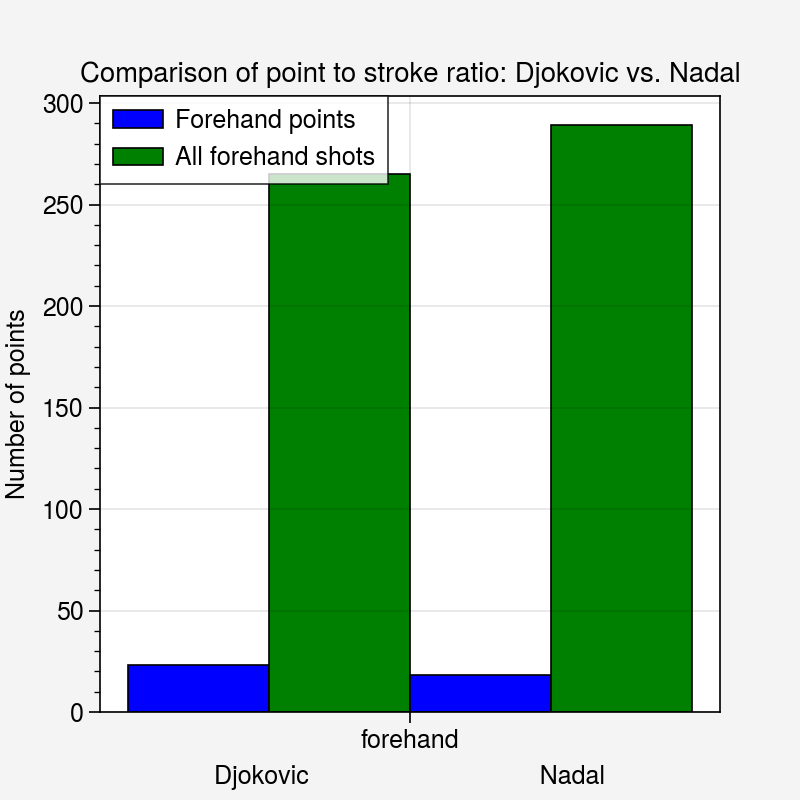

In [31]:
plt.hist([dj,dj_strks,nadal,nadal_strks], bins=1 , color=['blue','green','blue','green'],edgecolor='black', label= ['Forehand points', 'All forehand shots'])
plt.gca().set(title="Comparison of point to stroke ratio: Djokovic vs. Nadal",ylabel="Number of points",xlabel="Djokovic                                 Nadal")
plt.legend(loc='upper left')
plt.show()

In [34]:
#Ratio of points won over all rallies done with forehand: Djokovic vs. Nadal
dj_ratio = round(len(dj)/len(dj_strks)*100,2)
nadal_ratio = round(len(nadal)/len(nadal_strks)*100,2)
print(dj_ratio)
print(nadal_ratio)
print(len(dj))
print(len(nadal))
print(len(dj_strks))
print(len(nadal_strks))

8.68
6.23
23
18
265
289


# Analysis 2

# Graphing the court 

### This code has been taken from Kaggle

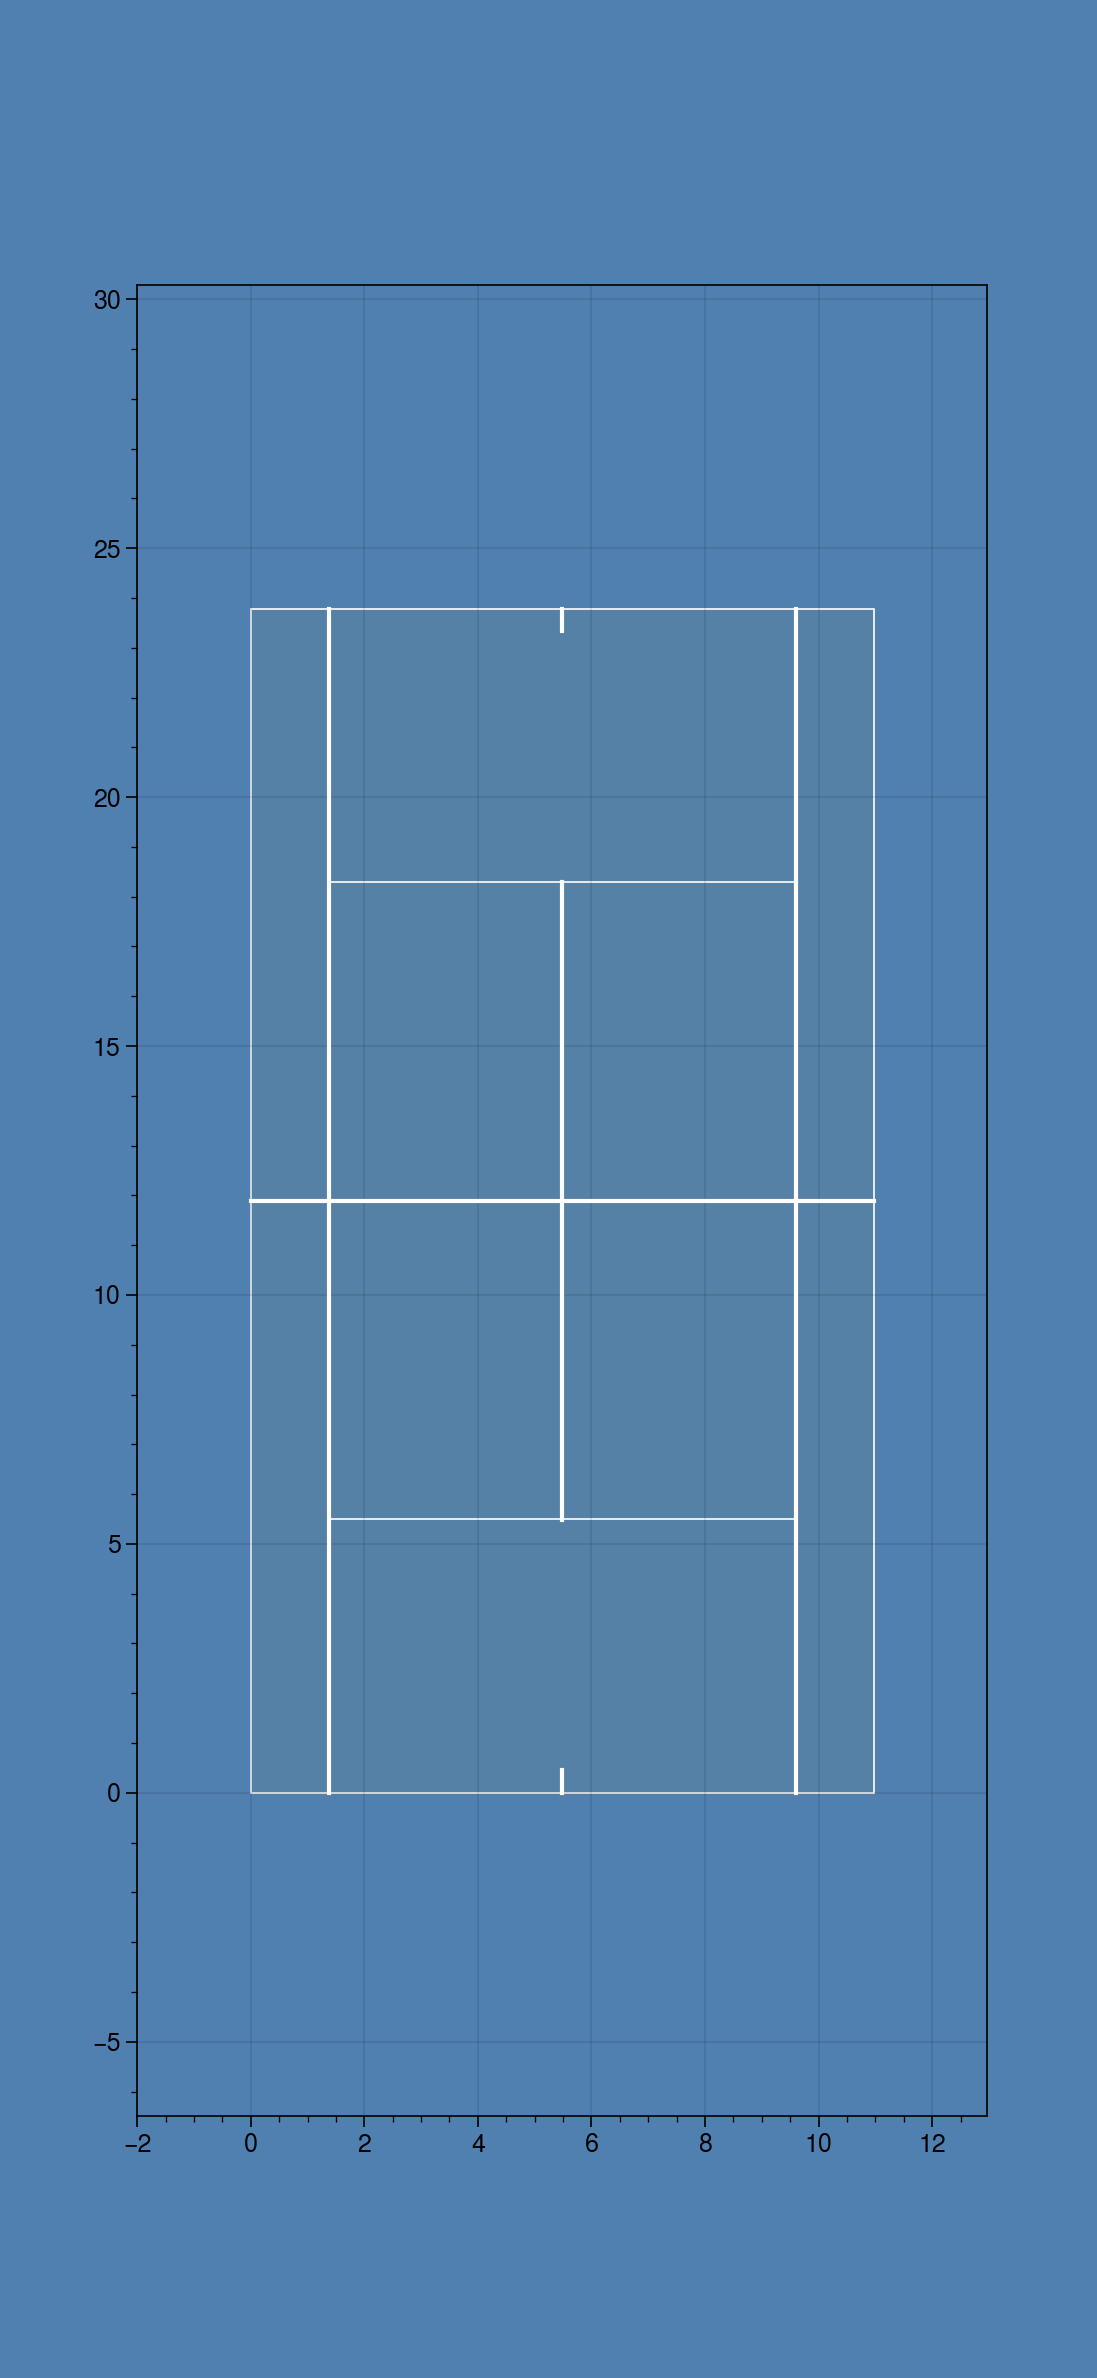

In [17]:
#### Tennis data

height_court = 10.97
width_court = 11.89*2
service_box = 6.4
double_field = 1.37
baseline_serviceline = 5.5
breite_einzel = 8.23
serviceline_net = 6.4


def draw_court(hide_axes=False):
    """Sets up field
    Returns matplotlib fig and axes objects.
    """
        
    fig = plt.figure(figsize=(height_court/2, width_court/2))
    #fig = plt.figure(figsize=(9, 9))
    fig.patch.set_facecolor('#5080B0')

    axes = fig.add_subplot(1, 1, 1, facecolor='#5080B0')

    if hide_axes:
        axes.xaxis.set_visible(False)
        axes.yaxis.set_visible(False)
        axes.axis('off')

    axes = draw_patches(axes)
    
    return fig, axes

def draw_patches(axes):
    plt.xlim([-2,height_court+2])
    plt.ylim([-6.5,width_court+6.5])
    
    #net
    axes.add_line(plt.Line2D([height_court, 0],[width_court/2, width_court/2],
                    c='w'))
    
    # court outline
    y = 0
    dy = width_court
    x = 0 #height_court-double_field
    dx = height_court
    axes.add_patch(plt.Rectangle((x, y), dx, dy,
                       edgecolor="white", facecolor="#5581A6", alpha=1))
    # serving rect
    y = baseline_serviceline
    dy = serviceline_net*2
    x = 0 + double_field 
    dx = breite_einzel
    axes.add_patch(plt.Rectangle((x, y), dx, dy,
                       edgecolor="white", facecolor="none", alpha=1))
    
    #?
    #net
    axes.add_line(plt.Line2D([height_court/2, height_court/2], [width_court/2 - service_box, width_court/2 + service_box],
                    c='w'))
    
    axes.add_line(plt.Line2D([height_court/2, height_court/2], [0, 0 + 0.45], 
                    c='w'))

    axes.add_line(plt.Line2D([height_court/2, height_court/2], [width_court, width_court - 0.45], 
                c='w'))
    
    axes.add_line(plt.Line2D([1.37, 1.37], [0, width_court], 
            c='w'))
    
    axes.add_line(plt.Line2D( [height_court - 1.37, height_court - 1.37], [0, width_court],
        c='w'))

    return axes

fig, ax = draw_court();


## Examining where the ball lands after all serves for each player

### Analysis through heatmaps

c:\users\serka71\anaconda3\envs\sports\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
c:\users\serka71\anaconda3\envs\sports\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


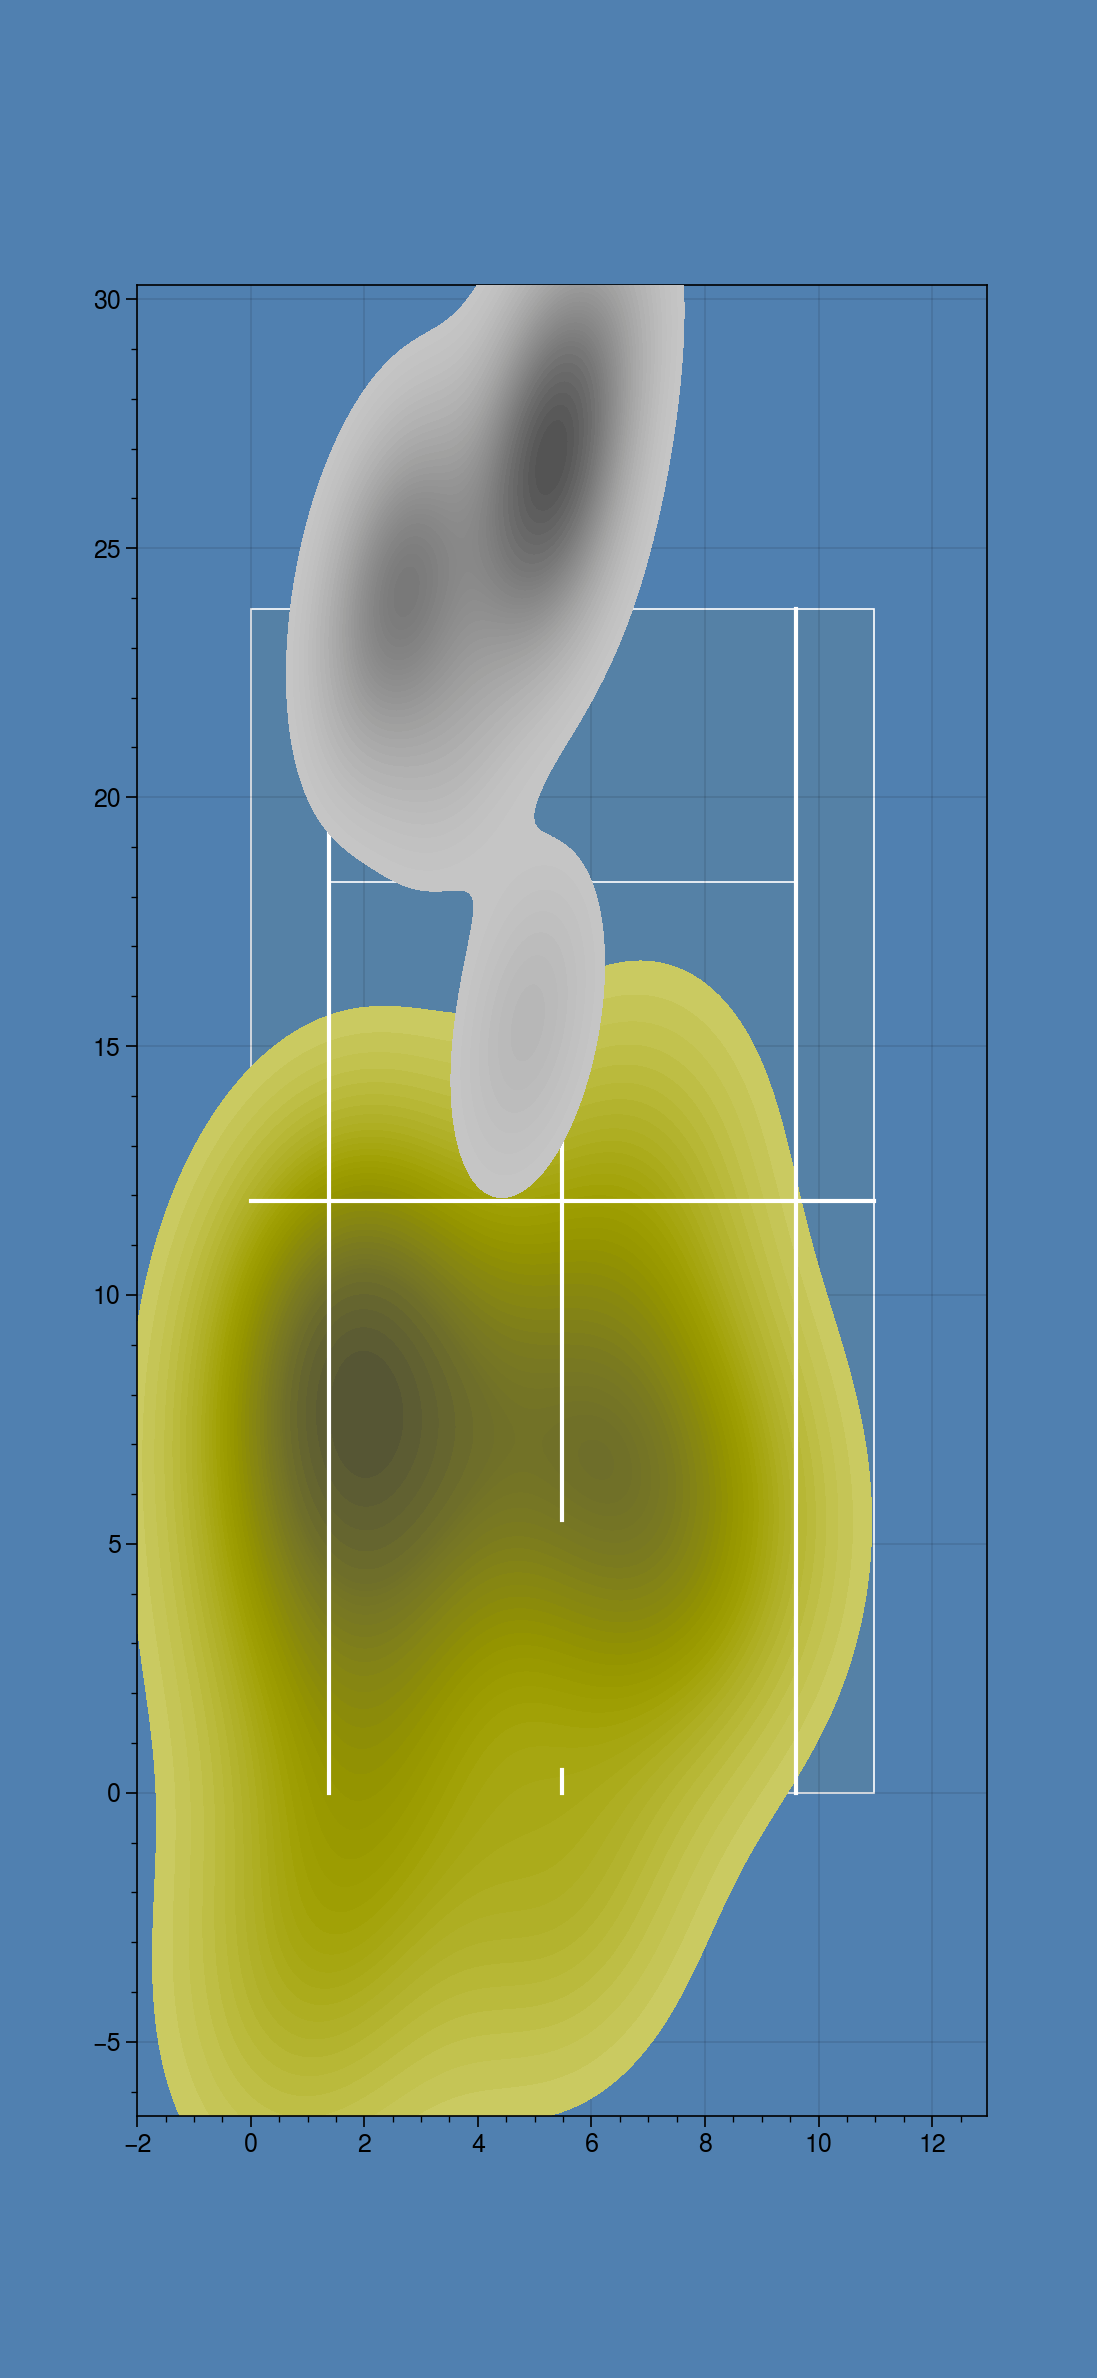

In [36]:
fig, ax = draw_court(hide_axes=False);
ballx_coord = [i for i in dj_serves_up["x"]]
bally_coord = [i for i in dj_serves_up["y"]]
hitter_x=[i for i in dj_serves_up["hitter_x"]]
hitter_y=[i for i in dj_serves_up["hitter_y"]]
receiver_x=[i for i in dj_serves_up["receiver_x"]]
receiver_y=[i for i in dj_serves_up["receiver_y"]]

#shades: give us the heat map we desire
# n_levels: draw more lines, the larger n, the more blurry it looks
sb.kdeplot(ballx_coord, bally_coord, shade = "False", color = "yellow", n_levels = 40,zorder=2)
sb.kdeplot(hitter_x, hitter_y, shade = "False", color = "black", n_levels = 40,zorder=7)
plt.show()



c:\users\serka71\anaconda3\envs\sports\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
c:\users\serka71\anaconda3\envs\sports\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


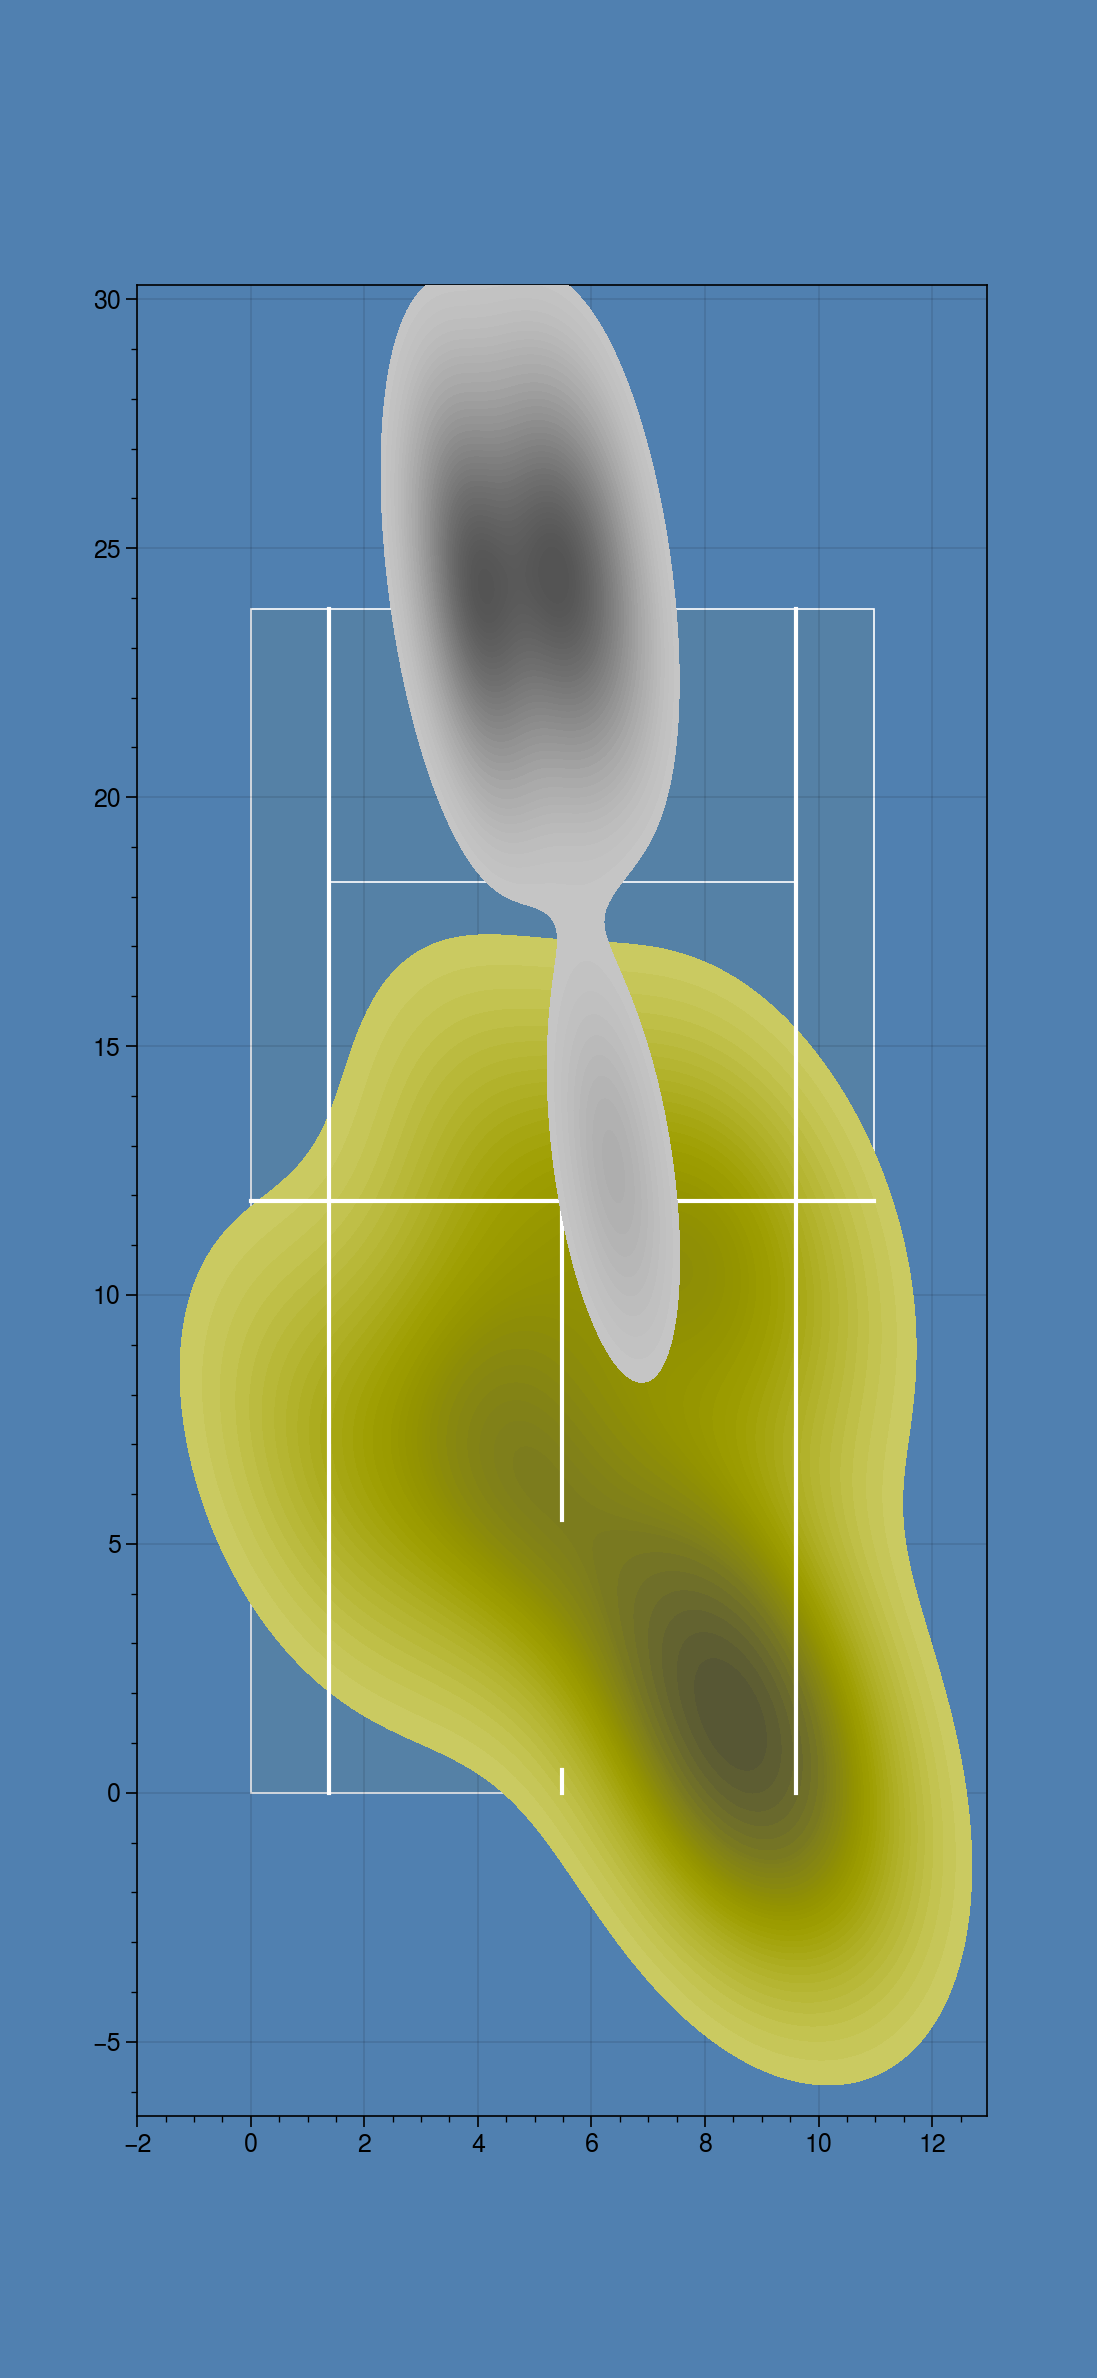

In [38]:
fig, ax = draw_court(hide_axes=False);
ballx_coord = [i for i in nadal_serves_up["x"]]
bally_coord = [i for i in nadal_serves_up["y"]]
hitter_x=[i for i in nadal_serves_up["hitter_x"]]
hitter_y=[i for i in nadal_serves_up["hitter_y"]]
receiver_x=[i for i in nadal_serves_up["receiver_x"]]
receiver_y=[i for i in nadal_serves_up["receiver_y"]]

#shades: give us the heat map we desire
# n_levels: draw more lines, the larger n, the more blurry it looks
sb.kdeplot(ballx_coord, bally_coord, shade = "False", color = "yellow", n_levels = 40,zorder=2)
sb.kdeplot(hitter_x, hitter_y, shade = "False", color = "black", n_levels = 40,zorder=7)
plt.show()

c:\users\serka71\anaconda3\envs\sports\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
c:\users\serka71\anaconda3\envs\sports\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


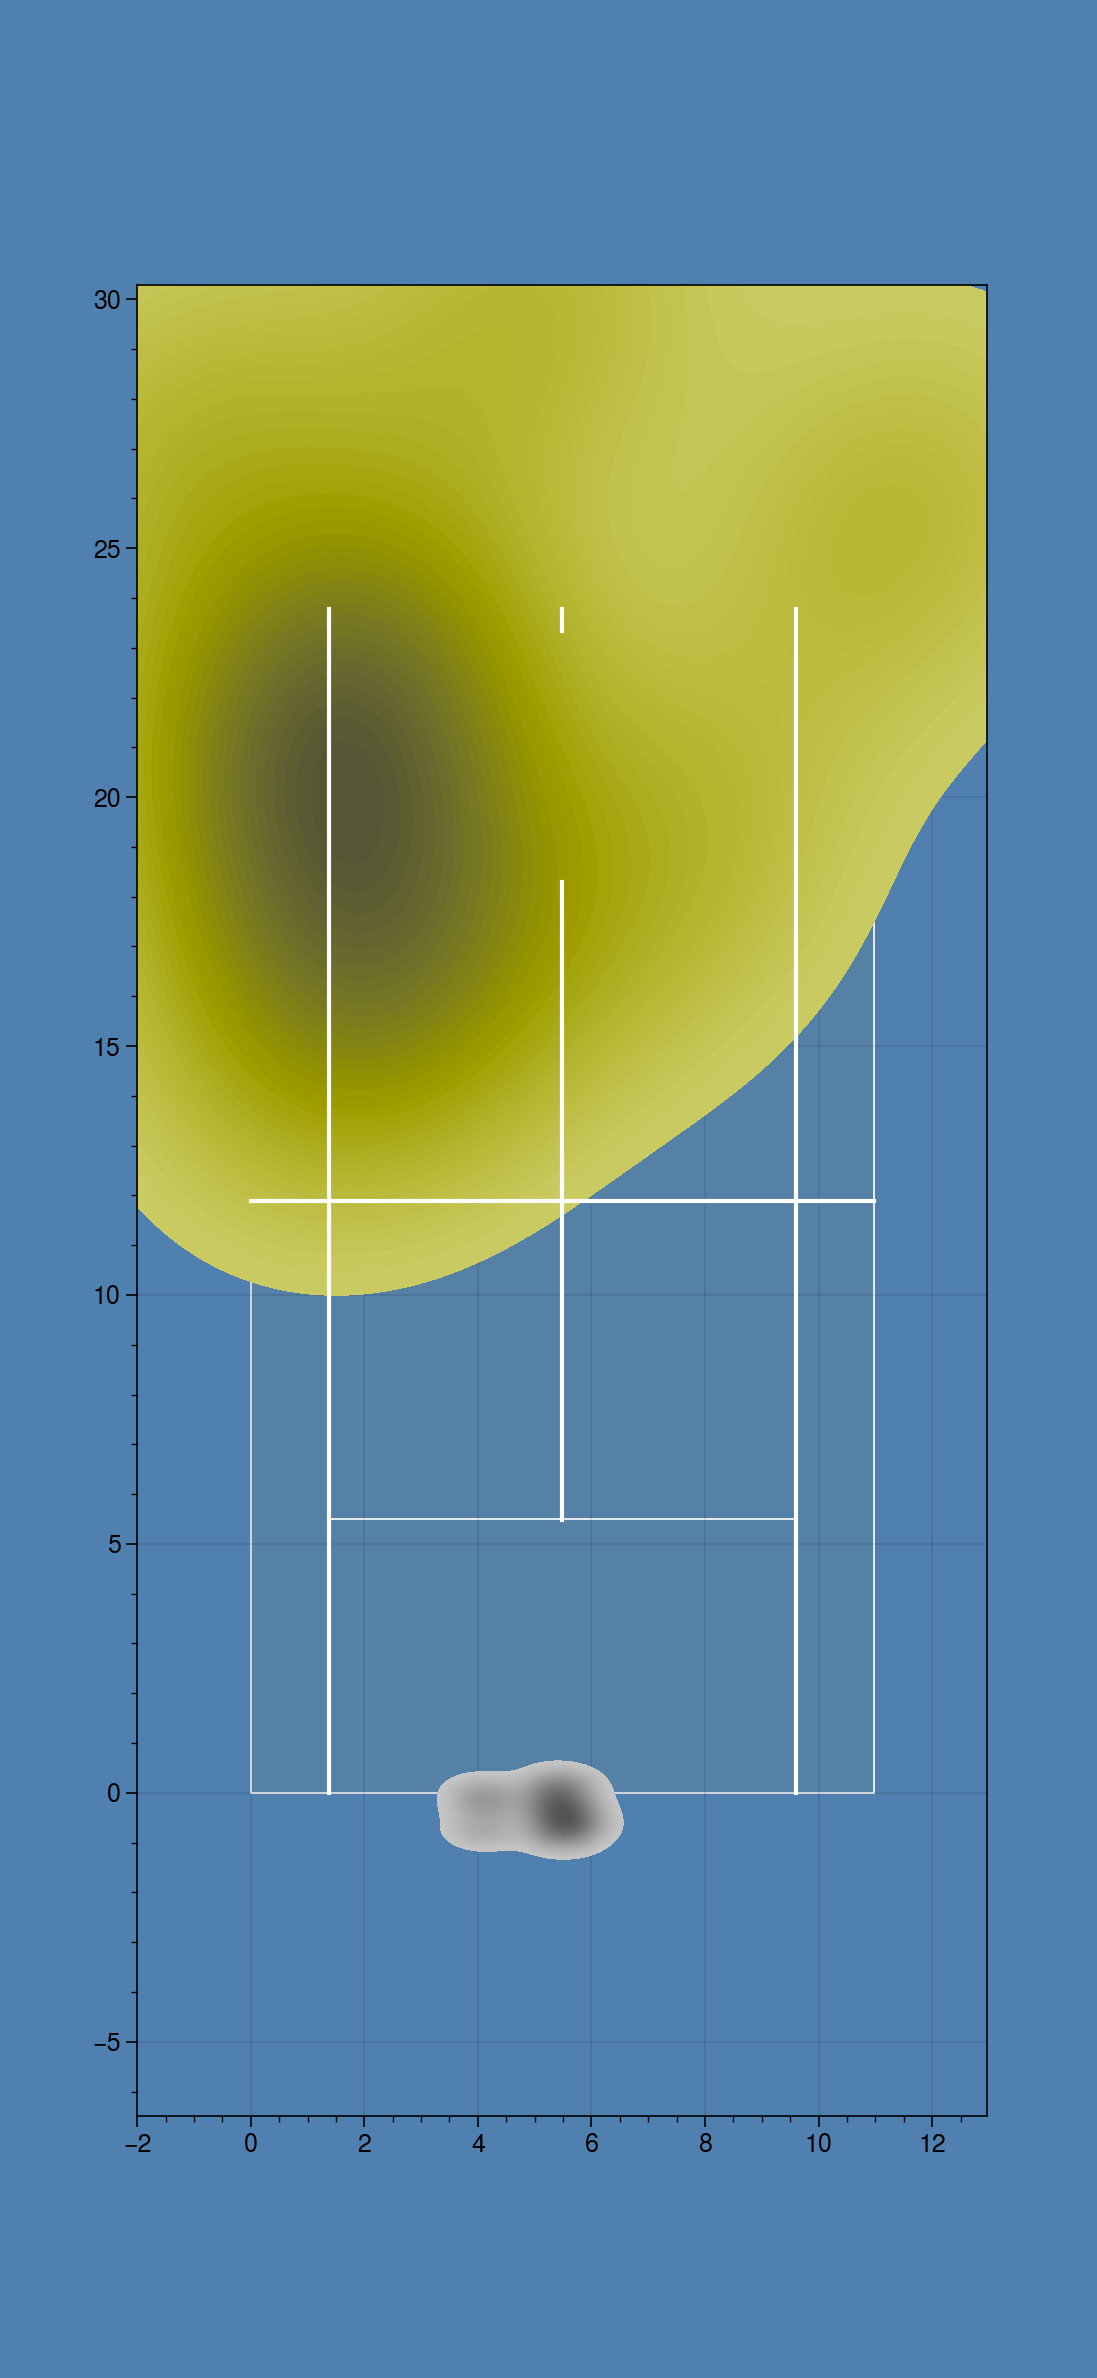

In [39]:
fig, ax = draw_court(hide_axes=False);
ballx_coord = [i for i in nadal_serves_down["x"]]
bally_coord = [i for i in nadal_serves_down["y"]]
hitter_x=[i for i in nadal_serves_down["hitter_x"]]
hitter_y=[i for i in nadal_serves_down["hitter_y"]]
receiver_x=[i for i in nadal_serves_down["receiver_x"]]
receiver_y=[i for i in nadal_serves_down["receiver_y"]]

#shades: give us the heat map we desire
# n_levels: draw more lines, the larger n, the more blurry it looks
sb.kdeplot(ballx_coord, bally_coord, shade = "False", color = "yellow", n_levels = 40,zorder=2)
sb.kdeplot(hitter_x, hitter_y, shade = "False", color = "black", n_levels = 40,zorder=7)
plt.show()

In [19]:
x=np.array(bally_coord).reshape((-1, 1))
y=np.array(hitter_y)


In [20]:
x_train = x[:-6]
x_test = x[-6:]
print(x_train)
print(x_test)

y_train = y[:-6]
y_test=y[-6:]
print(y_train)
print(y_test)

[[21.96]
 [17.18]
 [16.1 ]
 [18.13]]
[[20.36]
 [20.16]
 [29.27]
 [21.85]
 [21.55]
 [19.59]]
[-0.24 -0.1   1.78  0.09]
[-0.15 -0.39 -0.97 -0.65 -0.29 -0.15]


In [21]:

model = LinearRegression().fit(x_train,y_train)
model

LinearRegression()

In [22]:
r_sq = model.score(x, y)
r_sq
y_pred =model.predict(x_test)
print(y_test)
print(y_pred)

[-0.15 -0.39 -0.97 -0.65 -0.29 -0.15]
[-0.10996401 -0.06114478 -2.28486082 -0.47366729 -0.40043844  0.07799004]


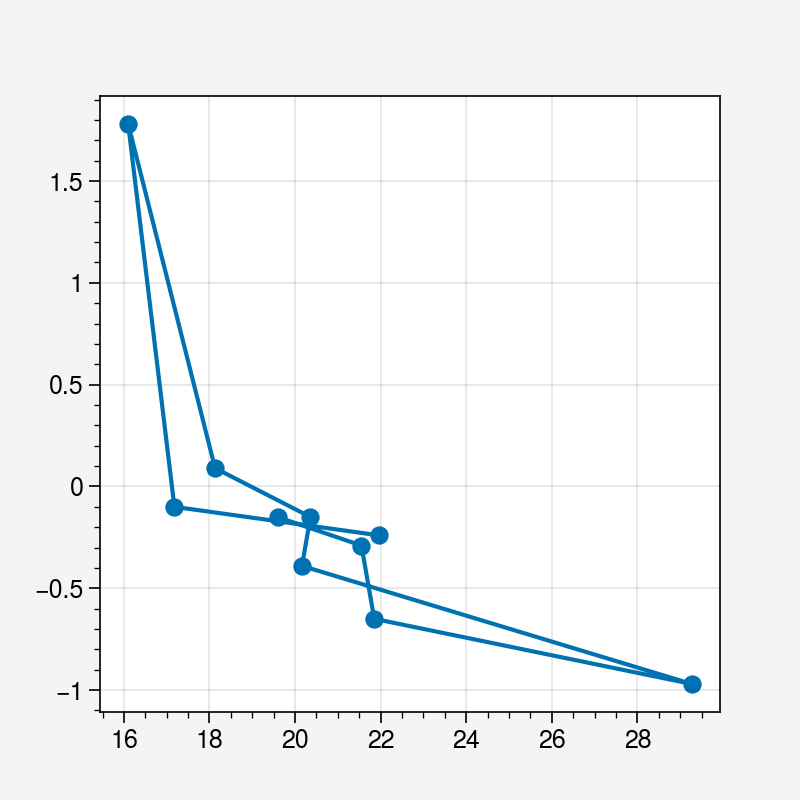

In [23]:
plt.scatter(x, y)
plt.plot(x, y);

In [24]:
plt.plot(year_test, times_pred, color='blue', linewidth =3, label = 'Trend line')

NameError: name 'year_test' is not defined

In [ ]:
plt.hist([hitter_y,bally_coord], bins=30 , color=['blue','green'],edgecolor='black', label= ['Forehand points', 'All forehand shots'])
plt.gca().set(title="Comparison of points scored with different strokes: Djokovic vs. Nadal",ylabel="Number of points",xlabel="Djokovic                                 Nadal")
plt.legend(loc='upper left')
plt.show()

In [ ]:
plt.scatter(bally_coord,hitter_y)

# Analysis 3

## Impact of pressure on the performance of each player

In [42]:


dj_hit_up['breakpoint']=""
dj_hit_up.loc[dj_hit_up['score'].str.contains(' 0:40'), 'breakpoint'] = 'yes'
dj_hit_up.loc[dj_hit_up['score'].str.contains(' 15:40'), 'breakpoint'] = 'yes'
dj_hit_up.loc[dj_hit_up['score'].str.contains(' 30:40'), 'breakpoint'] = 'yes'
dj_hit_up.loc[dj_hit_up['score'].str.contains(' 40:Ad'), 'breakpoint'] = 'yes'

dj_hit_up['trivialpoint']=""
dj_hit_up.loc[dj_hit_up['score'].str.contains(', 0:0'), 'trivialpoint'] = 'yes'
dj_hit_up.loc[dj_hit_up['score'].str.contains(', 0:15'), 'trivialpoint'] = 'yes'
dj_hit_up.loc[dj_hit_up['score'].str.contains(', 15:0'), 'trivialpoint'] = 'yes'
dj_hit_up.loc[dj_hit_up['score'].str.contains(', 15:15'), 'trivialpoint'] = 'yes'
dj_hit_up.loc[dj_hit_up['score'].str.contains(', 30:0'), 'trivialpoint'] = 'yes'

dj_hit_up['importantpoint']=""
dj_hit_up.loc[dj_hit_up['score'].str.contains(', 0:30'), 'importantpoint'] = 'yes'
dj_hit_up.loc[dj_hit_up['score'].str.contains(', 15:30'), 'importantpoint'] = 'yes'
dj_hit_up.loc[dj_hit_up['score'].str.contains(', 40:40'), 'importantpoint'] = 'yes'
dj_hit_up.loc[dj_hit_up['score'].str.contains(', 30:30'), 'importantpoint'] = 'yes'

dj_hit_up['gamepoint']=""
dj_hit_up.loc[dj_hit_up['score'].str.contains(', 40:0'), 'gamepoint'] = 'yes'
dj_hit_up.loc[dj_hit_up['score'].str.contains(', 40:15'), 'gamepoint'] = 'yes'
dj_hit_up.loc[dj_hit_up['score'].str.contains(', 40:30'), 'gamepoint'] = 'yes'
dj_hit_up.loc[dj_hit_up['score'].str.contains(', Ad:40'), 'gamepoint'] = 'yes'

##DJOKOVIC down##

dj_hit_down['breakpoint']=""
dj_hit_down.loc[dj_hit_down['score'].str.contains(' 0:40'), 'breakpoint'] = 'yes'
dj_hit_down.loc[dj_hit_down['score'].str.contains(' 15:40'), 'breakpoint'] = 'yes'
dj_hit_down.loc[dj_hit_down['score'].str.contains(' 30:40'), 'breakpoint'] = 'yes'
dj_hit_down.loc[dj_hit_down['score'].str.contains(' 40:Ad'), 'breakpoint'] = 'yes'

dj_hit_down['trivialpoint']=""
dj_hit_down.loc[dj_hit_down['score'].str.contains(', 0:0'), 'trivialpoint'] = 'yes'
dj_hit_down.loc[dj_hit_down['score'].str.contains(', 0:15'), 'trivialpoint'] = 'yes'
dj_hit_down.loc[dj_hit_down['score'].str.contains(', 15:0'), 'trivialpoint'] = 'yes'
dj_hit_down.loc[dj_hit_down['score'].str.contains(', 15:15'), 'trivialpoint'] = 'yes'
dj_hit_down.loc[dj_hit_down['score'].str.contains(', 30:0'), 'trivialpoint'] = 'yes'


dj_hit_down['importantpoint']=""
dj_hit_down.loc[dj_hit_down['score'].str.contains(', 0:30'), 'importantpoint'] = 'yes'
dj_hit_down.loc[dj_hit_down['score'].str.contains(', 15:30'), 'importantpoint'] = 'yes'
dj_hit_down.loc[dj_hit_down['score'].str.contains(', 40:40'), 'importantpoint'] = 'yes'
dj_hit_down.loc[dj_hit_down['score'].str.contains(', 30:30'), 'importantpoint'] = 'yes'

dj_hit_down['gamepoint']=""
dj_hit_down.loc[dj_hit_down['score'].str.contains(', 40:0'), 'gamepoint'] = 'yes'
dj_hit_down.loc[dj_hit_down['score'].str.contains(', 40:15'), 'gamepoint'] = 'yes'
dj_hit_down.loc[dj_hit_down['score'].str.contains(', 40:30'), 'gamepoint'] = 'yes'
dj_hit_down.loc[dj_hit_down['score'].str.contains(', Ad:40'), 'gamepoint'] = 'yes'

In [43]:
###DIVING BY TYPE OF POINT###
##NADAL up##

nadal_hit_up['breakpoint']=""
nadal_hit_up.loc[nadal_hit_up['score'].str.contains(', 40:15'), 'breakpoint'] = 'yes'
nadal_hit_up.loc[nadal_hit_up['score'].str.contains(', 40:0'), 'breakpoint'] = 'yes'
nadal_hit_up.loc[nadal_hit_up['score'].str.contains(', 40:30'), 'breakpoint'] = 'yes'
nadal_hit_up.loc[nadal_hit_up['score'].str.contains(', Ad:40'), 'breakpoint'] = 'yes'

nadal_hit_up['trivialpoint']=""
nadal_hit_up.loc[nadal_hit_up['score'].str.contains(', 0:0'), 'trivialpoint'] = 'yes'
nadal_hit_up.loc[nadal_hit_up['score'].str.contains(', 0:15'), 'trivialpoint'] = 'yes'
nadal_hit_up.loc[nadal_hit_up['score'].str.contains(', 15:0'), 'trivialpoint'] = 'yes'
nadal_hit_up.loc[nadal_hit_up['score'].str.contains(', 15:15'), 'trivialpoint'] = 'yes'
nadal_hit_up.loc[nadal_hit_up['score'].str.contains(', 0:30'), 'trivialpoint'] = 'yes'

nadal_hit_up['importantpoint']=""
nadal_hit_up.loc[nadal_hit_up['score'].str.contains(', 30:0'), 'importantpoint'] = 'yes'
nadal_hit_up.loc[nadal_hit_up['score'].str.contains(', 30:15'), 'importantpoint'] = 'yes'
nadal_hit_up.loc[nadal_hit_up['score'].str.contains(', 40:40'), 'importantpoint'] = 'yes'
nadal_hit_up.loc[nadal_hit_up['score'].str.contains(', 30:30'), 'importantpoint'] = 'yes'

nadal_hit_up['gamepoint']=""
nadal_hit_up.loc[nadal_hit_up['score'].str.contains(', 0:40'), 'gamepoint'] = 'yes'
nadal_hit_up.loc[nadal_hit_up['score'].str.contains(', 15:40'), 'gamepoint'] = 'yes'
nadal_hit_up.loc[nadal_hit_up['score'].str.contains(', 30:40'), 'gamepoint'] = 'yes'
nadal_hit_up.loc[nadal_hit_up['score'].str.contains(', 40:Ad'), 'gamepoint'] = 'yes'

##NADAL down##

nadal_hit_down['breakpoint']=""
nadal_hit_down.loc[nadal_hit_down['score'].str.contains(', 40:15'), 'breakpoint'] = 'yes'
nadal_hit_down.loc[nadal_hit_down['score'].str.contains(', 40:0'), 'breakpoint'] = 'yes'
nadal_hit_down.loc[nadal_hit_down['score'].str.contains(', 40:30'), 'breakpoint'] = 'yes'
nadal_hit_down.loc[nadal_hit_down['score'].str.contains(', Ad:40'), 'breakpoint'] = 'yes'

nadal_hit_down['trivialpoint']=""
nadal_hit_down.loc[nadal_hit_down['score'].str.contains(', 0:0'), 'trivialpoint'] = 'yes'
nadal_hit_down.loc[nadal_hit_down['score'].str.contains(', 0:15'), 'trivialpoint'] = 'yes'
nadal_hit_down.loc[nadal_hit_down['score'].str.contains(', 15:0'), 'trivialpoint'] = 'yes'
nadal_hit_down.loc[nadal_hit_down['score'].str.contains(', 15:15'), 'trivialpoint'] = 'yes'
nadal_hit_down.loc[nadal_hit_down['score'].str.contains(', 0:30'), 'trivialpoint'] = 'yes'

nadal_hit_down['importantpoint']=""
nadal_hit_down.loc[nadal_hit_down['score'].str.contains(', 30:0'), 'importantpoint'] = 'yes'
nadal_hit_down.loc[nadal_hit_down['score'].str.contains(', 30:15'), 'importantpoint'] = 'yes'
nadal_hit_down.loc[nadal_hit_down['score'].str.contains(', 40:40'), 'importantpoint'] = 'yes'
nadal_hit_down.loc[nadal_hit_down['score'].str.contains(', 30:30'), 'importantpoint'] = 'yes'

nadal_hit_down['gamepoint']=""
nadal_hit_down.loc[nadal_hit_down['score'].str.contains(', 0:40'), 'gamepoint'] = 'yes'
nadal_hit_down.loc[nadal_hit_down['score'].str.contains(', 15:40'), 'gamepoint'] = 'yes'
nadal_hit_down.loc[nadal_hit_down['score'].str.contains(', 30:40'), 'gamepoint'] = 'yes'
nadal_hit_down.loc[nadal_hit_down['score'].str.contains(', 40:Ad'), 'gamepoint'] = 'yes'


In [44]:
dj_hit_up

,index,rallyid,hitter,server,winner,receiver,stroke,type,hitter_x,hitter_y,...,type_of_point,grouped_point,score,reason_tp,hitter_tp,winner_tp,breakpoint,trivialpoint,importantpoint,gamepoint
1,7,3,Nadal,Djokovic,Djokovic,Djokovic,forehand,topspin,8.14,27.07,...,out,fake point,"0:0, 30:0",ace,Djokovic,Djokovic,,yes,,
29,157,42,Djokovic,Nadal,Nadal,Nadal,forehand,volley,3.40,16.67,...,net,fake point,"4:1, 30:40",out,Djokovic,Nadal,yes,,,
33,184,48,Djokovic,Djokovic,Djokovic,Nadal,forehand,serve,2.55,24.33,...,winner,earned point,"4:2, 40:0",winner,Djokovic,Djokovic,,,,yes
35,192,51,Nadal,Nadal,Nadal,Djokovic,forehand,serve,4.01,24.00,...,winner,earned point,"5:2, 0:15",net,Djokovic,Nadal,,yes,,
38,222,57,Nadal,Nadal,Nadal,Djokovic,forehand,serve,5.32,23.89,...,winner,earned point,"5:3, 0:0",net,Djokovic,Nadal,,yes,,
40,242,60,Nadal,Djokovic,Djokovic,Djokovic,forehand,topspin,2.90,24.22,...,out,fake point,"5:3, 15:15",winner,Djokovic,Djokovic,,yes,,
51,311,77,Nadal,Djokovic,Djokovic,Djokovic,forehand,topspin,7.73,26.33,...,net,fake point,"6:3 0:1, 30:0",ace,Djokovic,Djokovic,,yes,,
58,348,86,Nadal,Nadal,Nadal,Djokovic,forehand,serve,3.72,24.00,...,winner,earned point,"6:3 1:1, 30:40",net,Djokovic,Nadal,yes,,,
85,537,125,Djokovic,Djokovic,Djokovic,Nadal,forehand,serve,3.64,21.85,...,winner,earned point,"6:3 5:2, 15:0",ace,Djokovic,Djokovic,,yes,,
86,540,126,Djokovic,Djokovic,Djokovic,Nadal,forehand,serve,5.38,25.14,...,ace,earned point,"6:3 5:2, 30:0",ace,Djokovic,Djokovic,,yes,,


In [50]:
##Data broken down into different types of points DJOKOVIC down & up sides

djtrivial_down=dj_hit_down[dj_hit_down.trivialpoint.str.len() >0]
djimportant_down=dj_hit_down[dj_hit_down.importantpoint.str.len() >0]
djgame_down=dj_hit_down[dj_hit_down.gamepoint.str.len() >0]
nadalbreak_down=dj_hit_down[dj_hit_down.breakpoint.str.len() >0]

djtrivial_up=dj_hit_up[dj_hit_up.trivialpoint.str.len() >0]
djimportant_up=dj_hit_up[dj_hit_up.importantpoint.str.len() >0]
djgame_up=dj_hit_up[dj_hit_up.gamepoint.str.len() >0]
nadalbreak_up=dj_hit_up[dj_hit_up.breakpoint.str.len() >0]
djtrivial_up

,index,rallyid,hitter,server,winner,receiver,stroke,type,hitter_x,hitter_y,...,type_of_point,grouped_point,score,reason_tp,hitter_tp,winner_tp,breakpoint,trivialpoint,importantpoint,gamepoint
1,7,3,Nadal,Djokovic,Djokovic,Djokovic,forehand,topspin,8.14,27.07,...,out,fake point,"0:0, 30:0",ace,Djokovic,Djokovic,,yes,,
35,192,51,Nadal,Nadal,Nadal,Djokovic,forehand,serve,4.01,24.00,...,winner,earned point,"5:2, 0:15",net,Djokovic,Nadal,,yes,,
38,222,57,Nadal,Nadal,Nadal,Djokovic,forehand,serve,5.32,23.89,...,winner,earned point,"5:3, 0:0",net,Djokovic,Nadal,,yes,,
40,242,60,Nadal,Djokovic,Djokovic,Djokovic,forehand,topspin,2.90,24.22,...,out,fake point,"5:3, 15:15",winner,Djokovic,Djokovic,,yes,,
51,311,77,Nadal,Djokovic,Djokovic,Djokovic,forehand,topspin,7.73,26.33,...,net,fake point,"6:3 0:1, 30:0",ace,Djokovic,Djokovic,,yes,,
85,537,125,Djokovic,Djokovic,Djokovic,Nadal,forehand,serve,3.64,21.85,...,winner,earned point,"6:3 5:2, 15:0",ace,Djokovic,Djokovic,,yes,,
86,540,126,Djokovic,Djokovic,Djokovic,Nadal,forehand,serve,5.38,25.14,...,ace,earned point,"6:3 5:2, 30:0",ace,Djokovic,Djokovic,,yes,,
98,603,146,Nadal,Djokovic,Djokovic,Djokovic,forehand,return,9.17,23.77,...,out,fake point,"6:3 6:2 1:1, 0:0",out,Djokovic,Nadal,,yes,,
104,649,155,Nadal,Nadal,Djokovic,Djokovic,forehand,slice,6.50,17.78,...,net,fake point,"6:3 6:2 2:1, 0:0",winner,Djokovic,Nadal,,yes,,
115,709,169,Nadal,Djokovic,Djokovic,Djokovic,forehand,stop,7.09,24.68,...,net,fake point,"6:3 6:2 3:2, 15:0",out,Djokovic,Nadal,,yes,,


In [46]:
nadaltrivial_down=nadal_hit_down[nadal_hit_down.trivialpoint.str.len() >0]
nadalimportant_down=nadal_hit_down[nadal_hit_down.importantpoint.str.len() >0]
nadalgame_down=nadal_hit_down[nadal_hit_down.gamepoint.str.len() >0]
djbreak_down=nadal_hit_down[nadal_hit_down.breakpoint.str.len() >0]

nadaltrivial_up=nadal_hit_up[nadal_hit_up.trivialpoint.str.len() >0]
nadalimportant_up=nadal_hit_up[nadal_hit_up.importantpoint.str.len() >0]
nadalgame_up=nadal_hit_up[nadal_hit_up.gamepoint.str.len() >0]
djbreak_up=nadal_hit_up[nadal_hit_up.breakpoint.str.len() >0]
nadaltrivial_down

,index,rallyid,hitter,server,winner,receiver,stroke,type,hitter_x,hitter_y,...,type_of_point,grouped_point,score,reason_tp,hitter_tp,winner_tp,breakpoint,trivialpoint,importantpoint,gamepoint
0,0,1,Djokovic,Djokovic,Djokovic,Nadal,forehand,serve,6.50,-0.24,...,winner,earned point,"0:0, 15:0",out,Nadal,Djokovic,,yes,,
4,28,8,Nadal,Nadal,Djokovic,Djokovic,forehand,topspin,2.72,-1.83,...,out,fake point,"1:0, 15:0",winner,Nadal,Djokovic,,yes,,
8,62,14,Nadal,Nadal,Djokovic,Djokovic,forehand,topspin,9.30,2.77,...,out,fake point,"2:0, 0:0",out,Nadal,Djokovic,,yes,,
9,64,15,Nadal,Djokovic,Djokovic,Djokovic,forehand,topspin,7.38,-2.53,...,out,fake point,"2:0, 15:0",out,Nadal,Djokovic,,yes,,
14,91,22,Djokovic,Nadal,Nadal,Nadal,forehand,topspin,0.97,0.61,...,out,fake point,"3:0, 15:15",winner,Nadal,Djokovic,,yes,,
21,117,31,Djokovic,Djokovic,Djokovic,Nadal,forehand,serve,5.97,1.78,...,ace,earned point,"3:1, 15:0",net,Nadal,Djokovic,,yes,,
24,125,34,Djokovic,Djokovic,Djokovic,Nadal,forehand,serve,4.02,-0.15,...,winner,earned point,"4:1, 0:0",out,Nadal,Djokovic,,yes,,
39,236,59,Djokovic,Djokovic,Nadal,Nadal,forehand,topspin,2.98,0.09,...,net,fake point,"5:3, 0:15",out,Nadal,Djokovic,,yes,,
44,285,65,Nadal,Nadal,Djokovic,Djokovic,forehand,volley,3.20,4.53,...,out,fake point,"6:3 0:0, 15:0",winner,Nadal,Nadal,,yes,,
49,299,73,Nadal,Nadal,Nadal,Djokovic,forehand,serve,4.08,-0.78,...,winner,earned point,"6:3 0:1, 0:0",net,Nadal,Djokovic,,yes,,


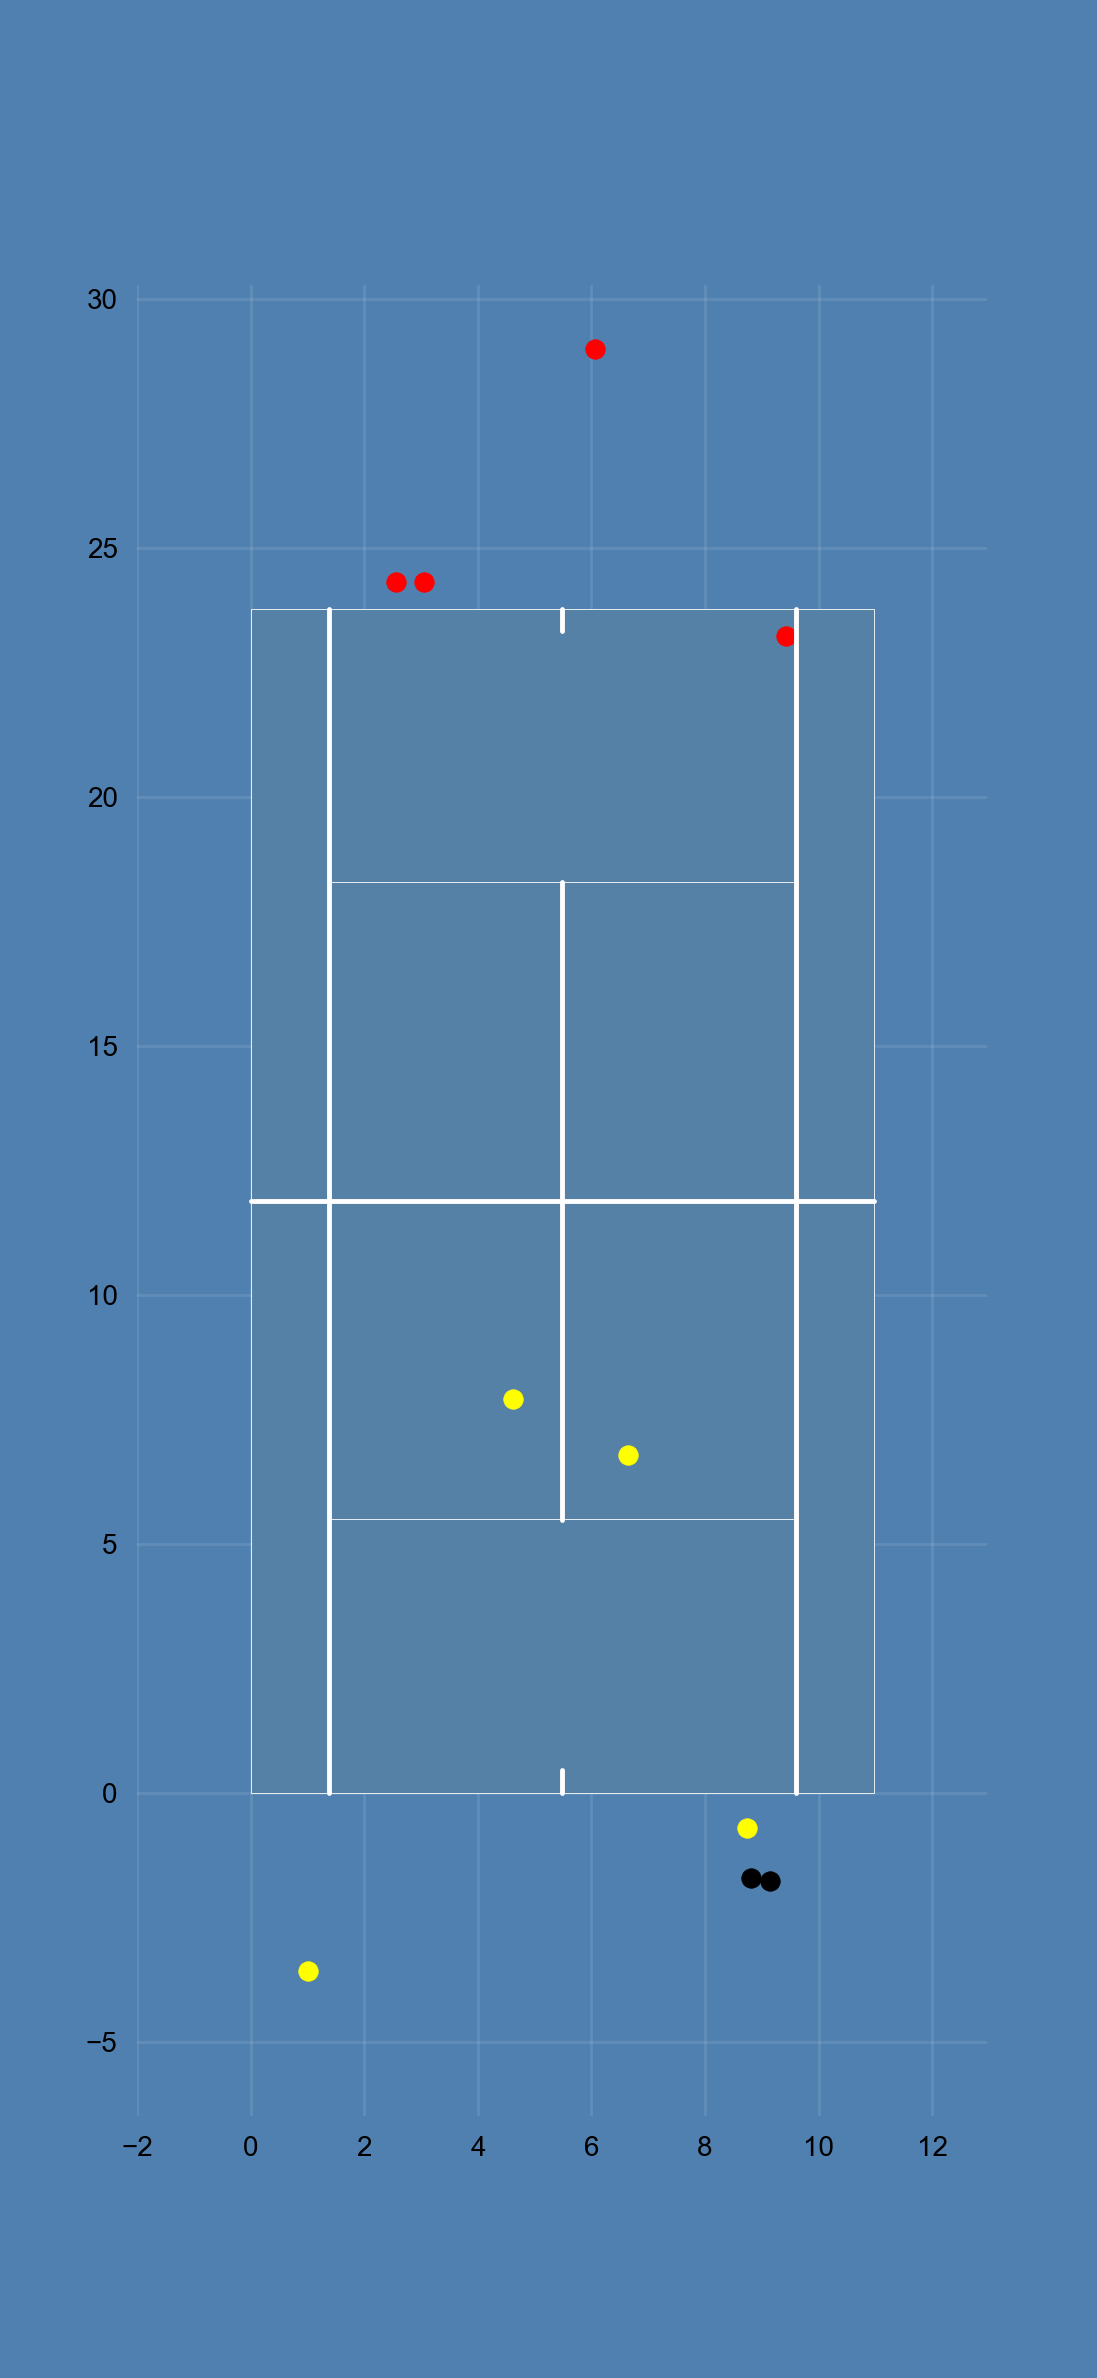

In [47]:
fig, ax = draw_court(hide_axes=False);
ballx_coord = [i for i in djgame_up["x"]]
bally_coord = [i for i in djgame_up["y"]]
hitter_x=[i for i in djgame_up["hitter_x"]]
hitter_y=[i for i in djgame_up["hitter_y"]]
receiver_x=[i for i in djgame_up["receiver_x"]]
receiver_y=[i for i in djgame_up["receiver_y"]]

ax.scatter(ballx_coord,bally_coord, color='yellow',zorder=2)
ax.scatter(hitter_x,hitter_y,color='red',zorder=2)
ax.scatter(receiver_x,receiver_y,color='black',zorder=2)

In [53]:
print((nadaltrivial_up['reason_tp']).value_counts())
print((nadalimportant_up['reason_tp']).value_counts())
print((nadalgame_up['reason_tp']).value_counts())
print((djbreak_up['reason_tp']).value_counts())


out             5
winner          5
double_fault    2
net             1
Name: reason_tp, dtype: int64
out       2
winner    2
net       1
Name: reason_tp, dtype: int64
out    1
Name: reason_tp, dtype: int64
net    1
out    1
Name: reason_tp, dtype: int64


In [54]:
print((nadaltrivial_down['reason_tp']).value_counts())
print((nadalimportant_down['reason_tp']).value_counts())
print((nadalgame_down['reason_tp']).value_counts())
print((djbreak_down['reason_tp']).value_counts())

out       6
winner    5
net       3
ace       1
Name: reason_tp, dtype: int64
net       3
out       3
ace       1
winner    1
Name: reason_tp, dtype: int64
winner    3
net       1
Name: reason_tp, dtype: int64
net    3
Name: reason_tp, dtype: int64


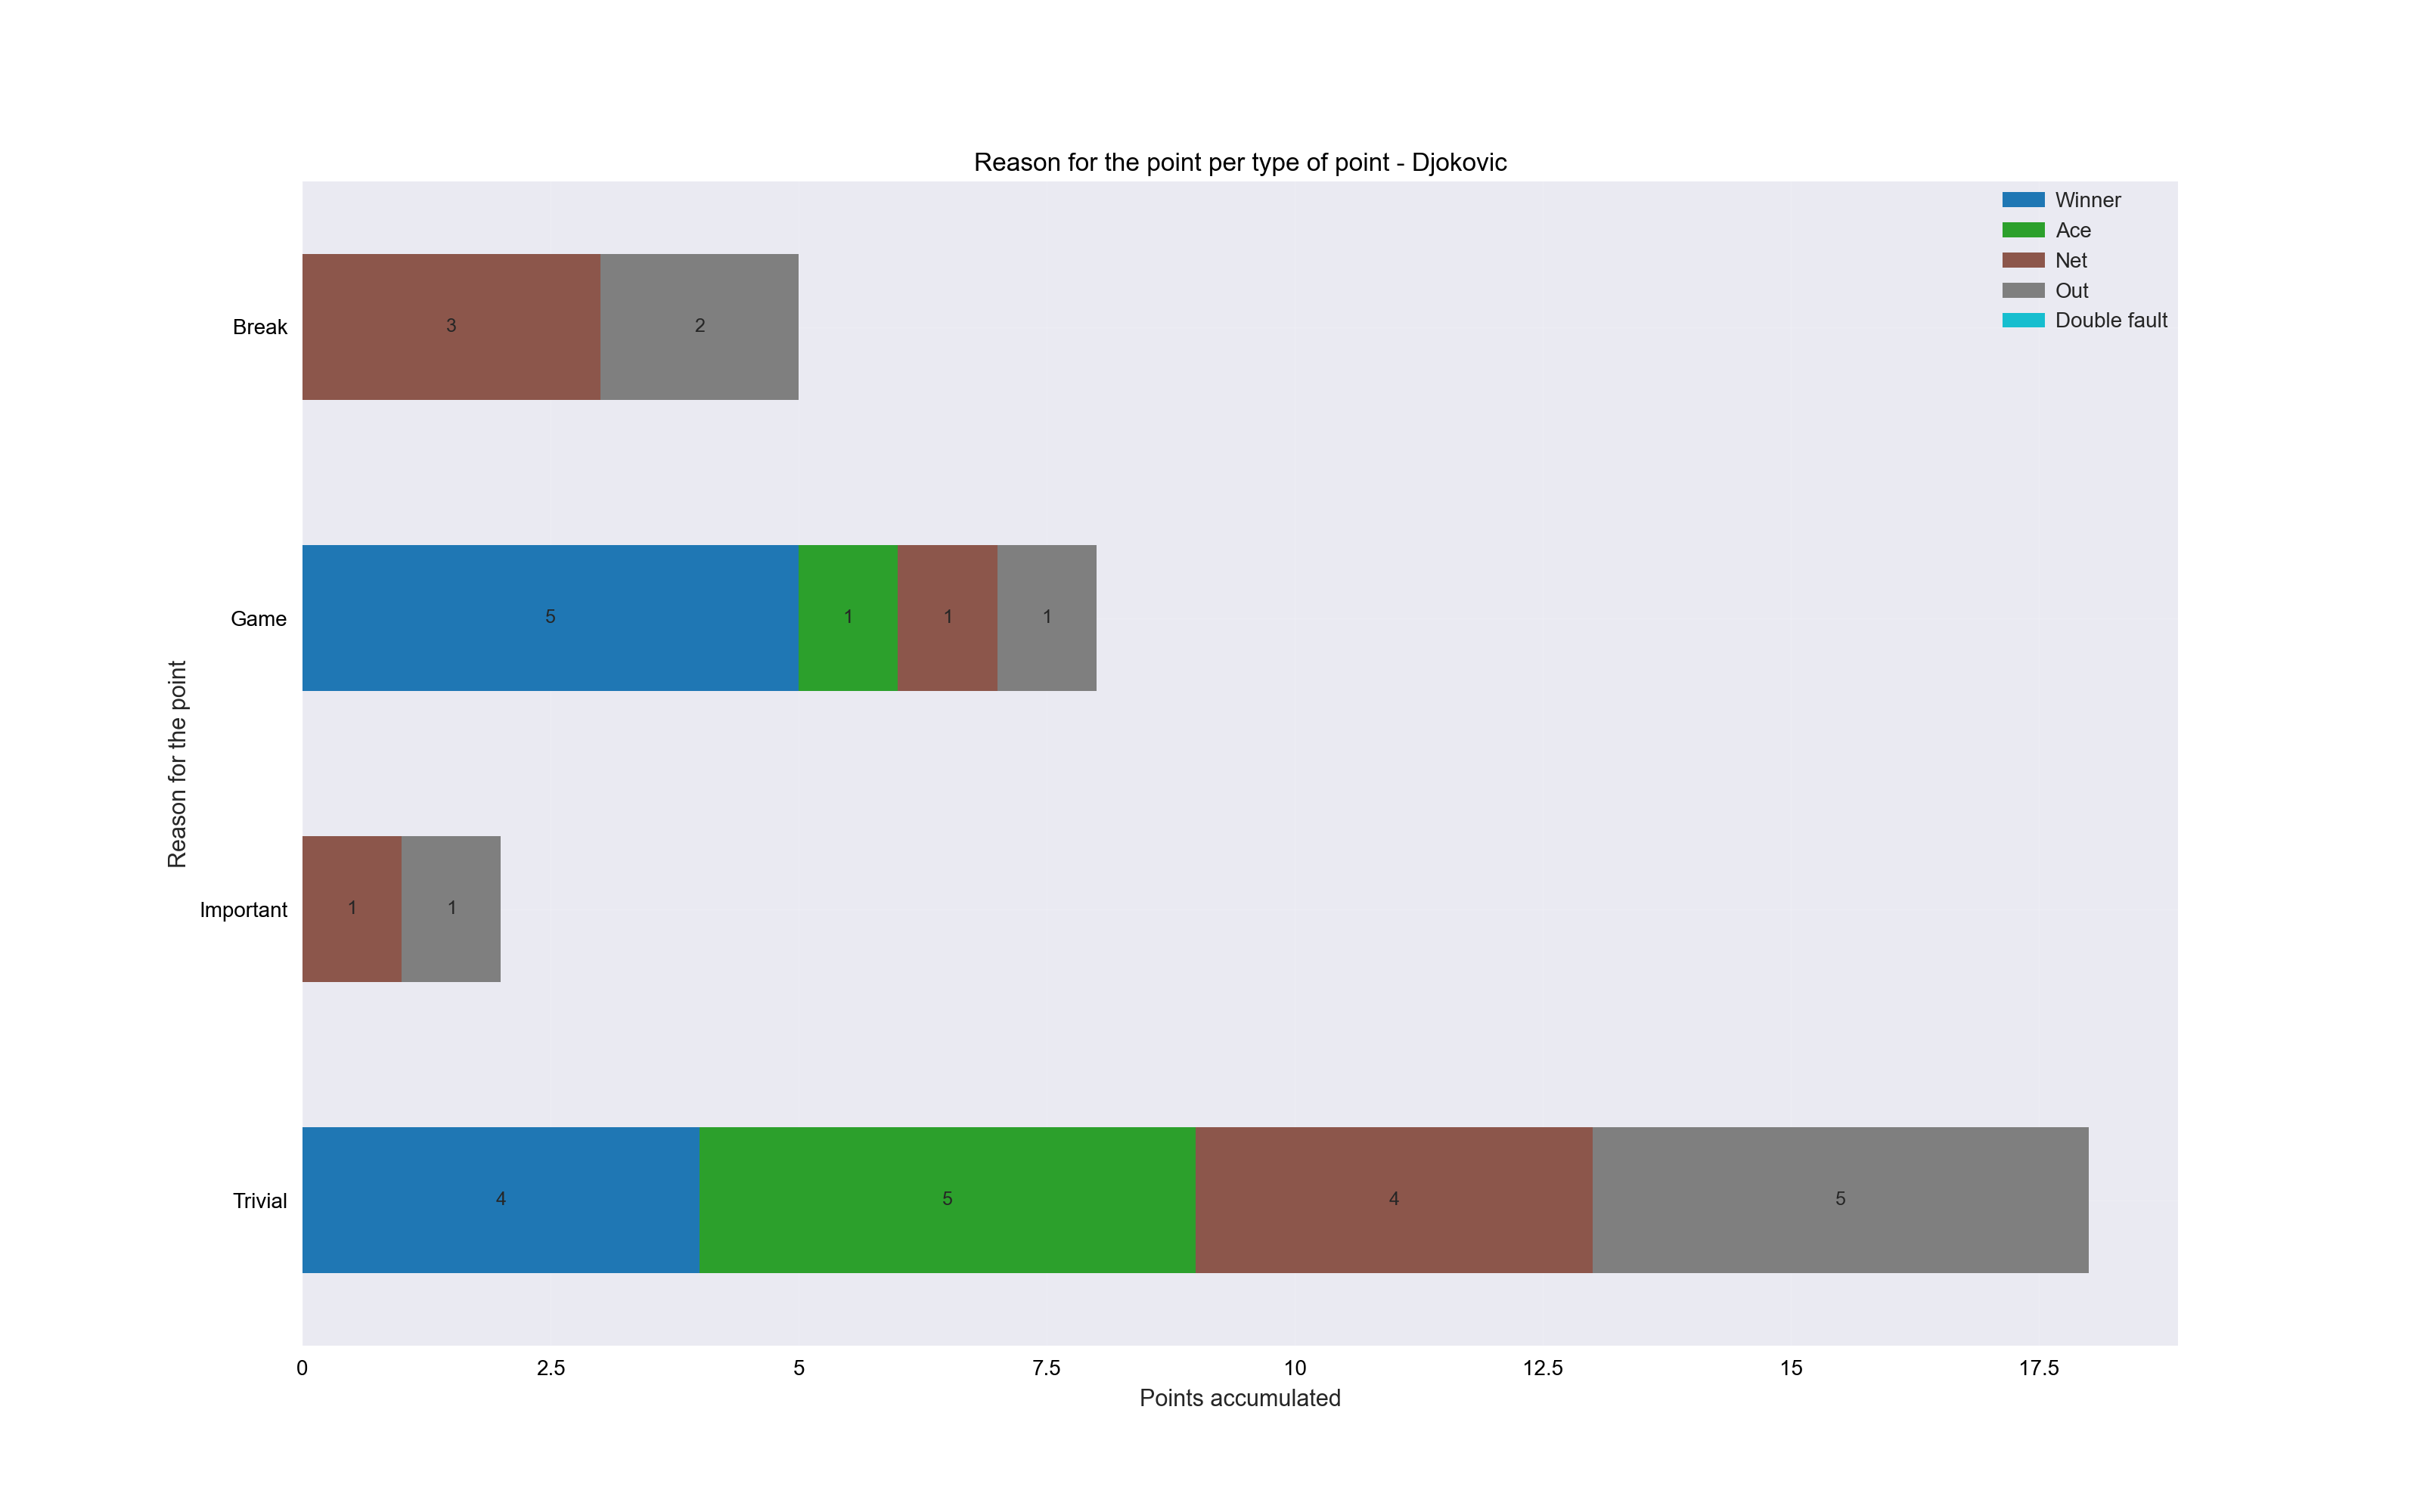

In [82]:
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (16.0, 10.0)

dj_reason_p1 = ['Winner', 'Ace', 'Net', 'Out', 'Double fault']
dj_type_p1 = {'Trivial': [4, 5, 4, 5,0],
           'Important': [0, 0, 1,1,0],
          'Game':[5,1,1,1, 0],
          'Break': [0,0,3,2,0]}

dj_type_p = ['Trivial', 'Important', 'Game', 'Break']
dj_reason_p ={'Winner':[4,0,5,0],
             'Ace':[5,0,1,0],
             'Net':[4,1,1,3],
             'Out':[5,1,1,2],
             'Double fault':[0,0,0,0]}




df_dj1 = pd.DataFrame(dj_reason_p, index=dj_type_p)
ax = df_dj1.plot.barh(stacked=True, cmap='tab10', figsize=(16, 10))
plt.gca().set(title="Reason for the point per type of point - Djokovic",ylabel="Reason for the point",xlabel="Points accumulated")

for p in ax.patches:
    left, bottom, width, height = p.get_bbox().bounds
    if width > 0:
         ax.annotate(f'{width:0.0f}', xy=(left+width/2, bottom+height/2), ha='center', va='center')
            

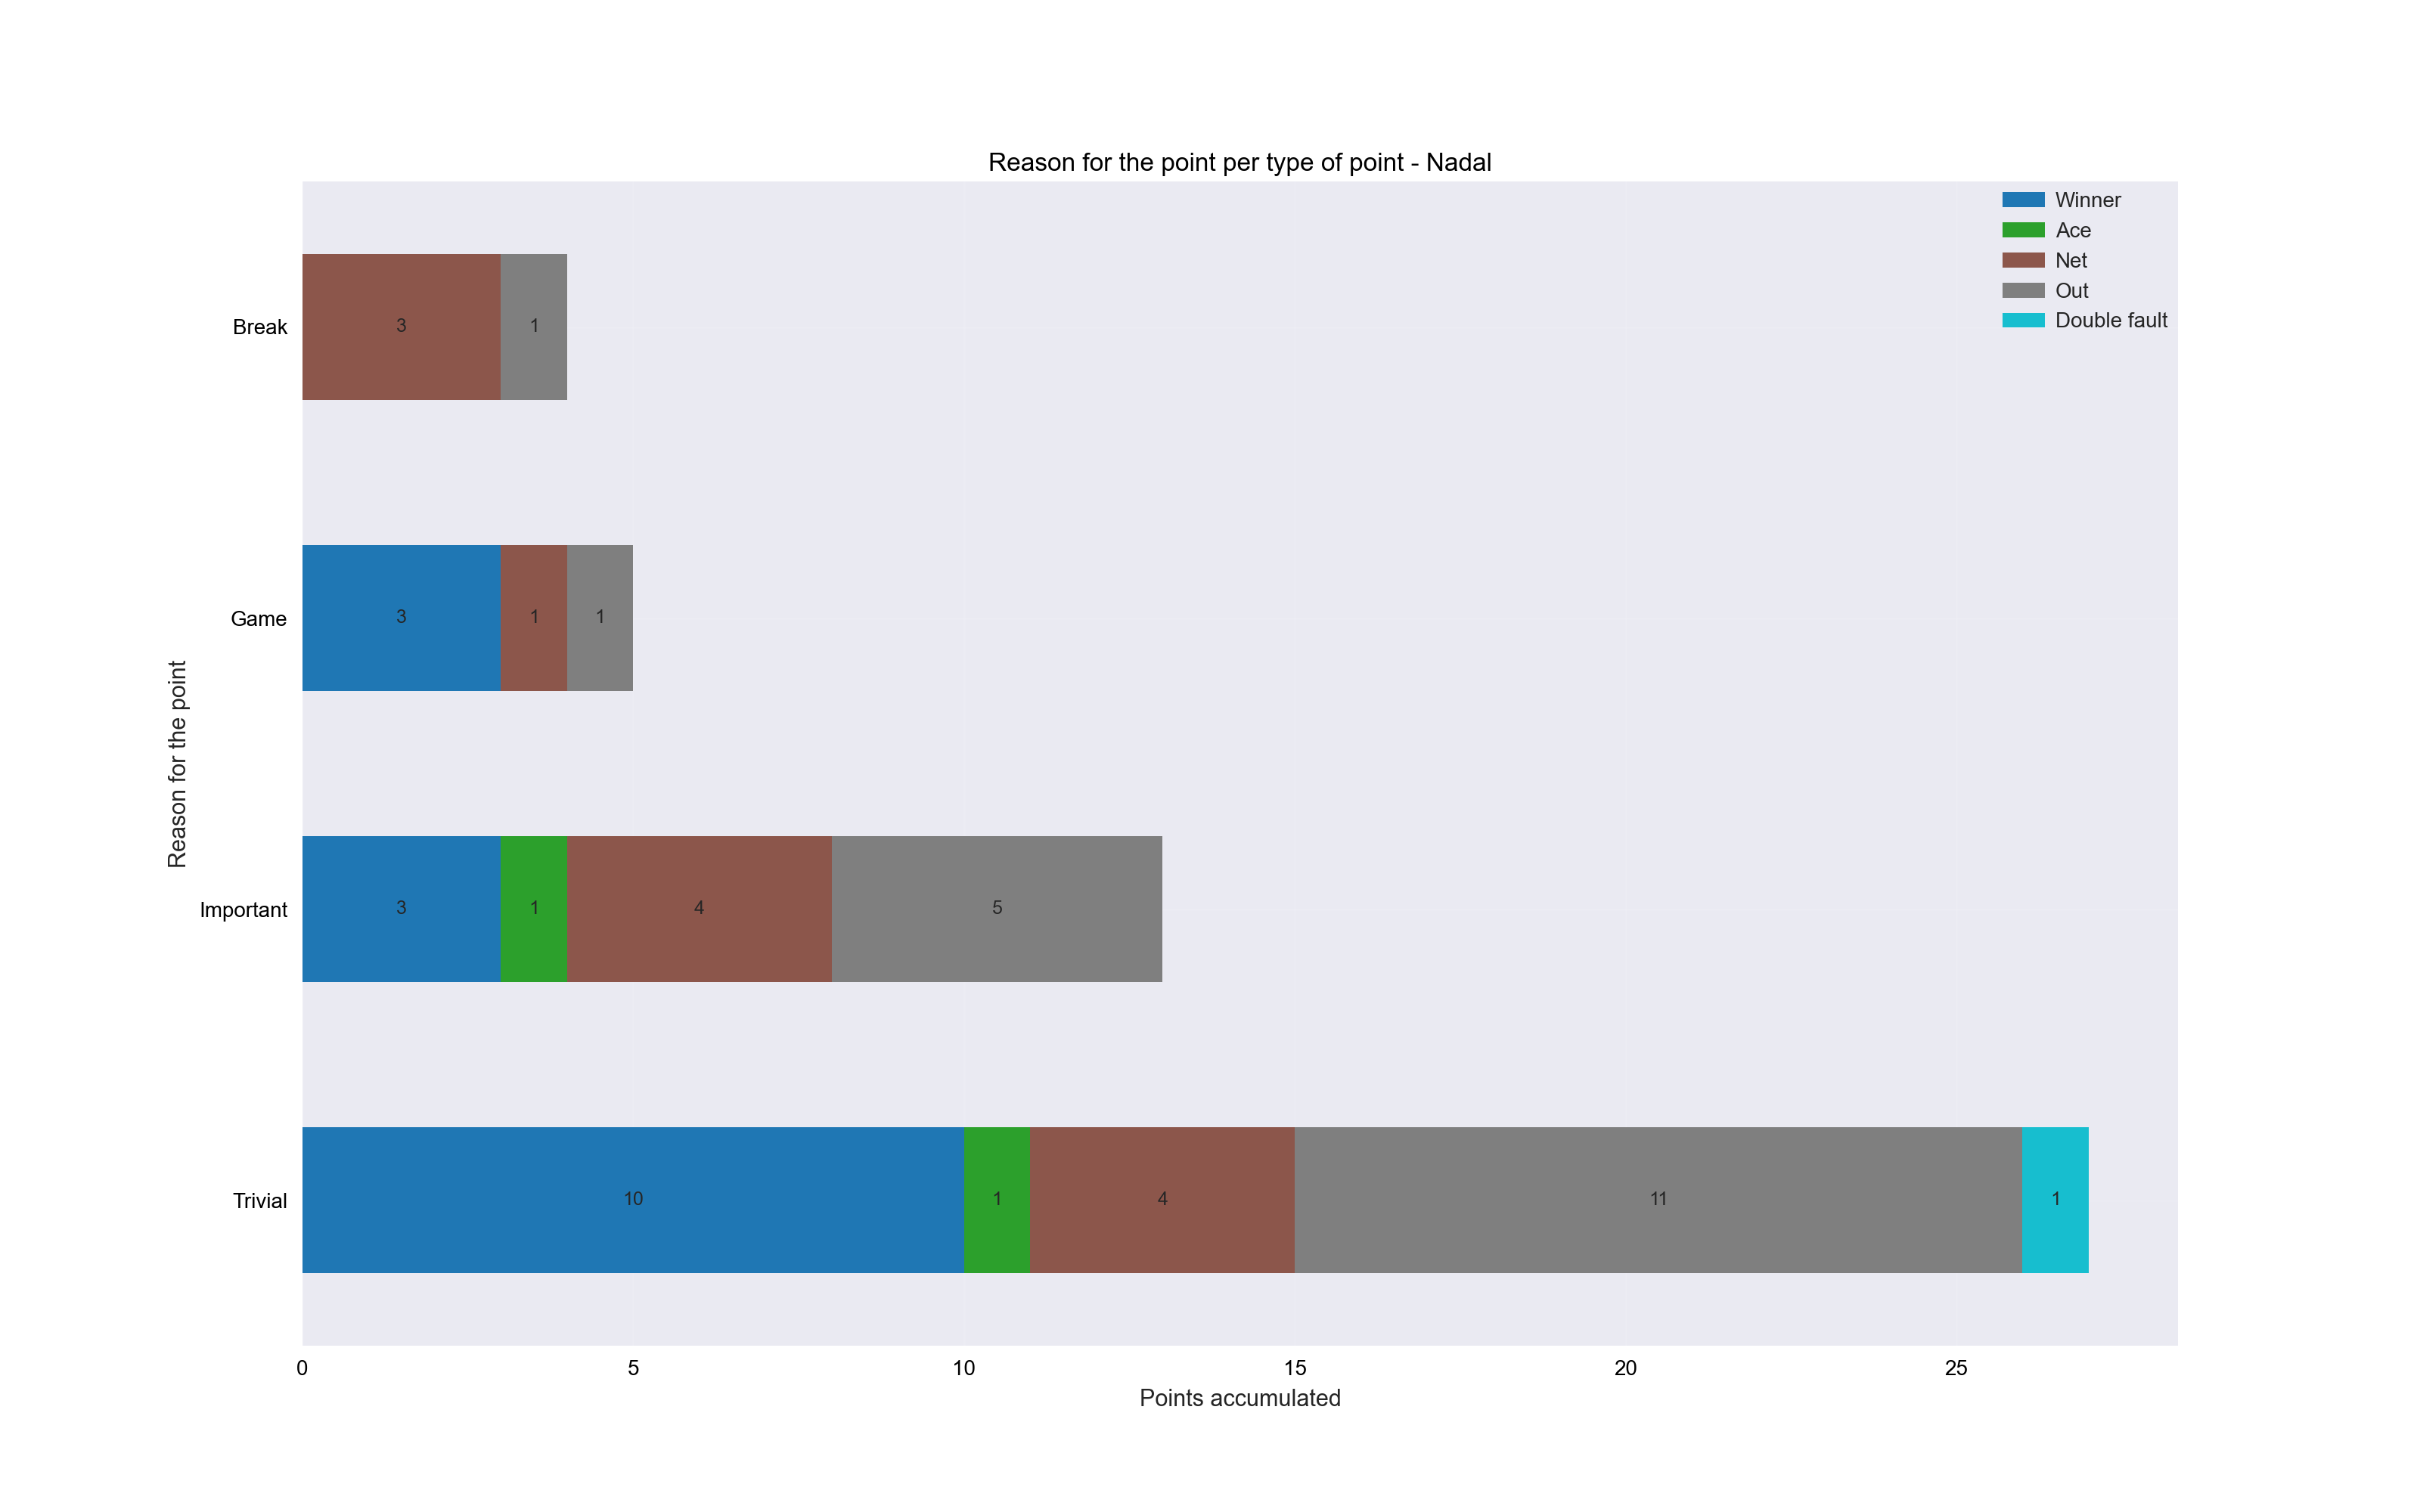

In [92]:
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (16.0, 10.0)

#nadal_reason_p = ['Winner', 'Ace', 'Net', 'Out', 'Double fault']
#nadal_type_p = {'Trivial': [10, 1, 4, 11,1],
#           'Important': [3, 1, 4, 5,0],
 #         'Game':[3,0,1,1,0],
  #        'Break':[0,0,3,1,0]}


nadal_type_p=['Trivial', 'Important', 'Game', 'Break']
nadal_reason_p={'Winner':[10,3,3,0],
             'Ace':[1,1,0,0],
             'Net':[4,4,1,3],
             'Out':[11,5,1,1],
             'Double fault':[1,0,0,0]}




df_nadal = pd.DataFrame(nadal_reason_p, index=nadal_type_p)
ax = df_nadal.plot.barh(stacked=True, cmap='tab10', figsize=(16, 10))
plt.gca().set(title="Reason for the point per type of point - Nadal",ylabel="Reason for the point",xlabel="Points accumulated")


for p in ax.patches:
    left, bottom, width, height = p.get_bbox().bounds
    if width > 0:
         ax.annotate(f'{width:0.0f}', xy=(left+width/2, bottom+height/2), ha='center', va='center')

